In [12]:
import sys
sys.dont_write_bytecode = True
import os
from itertools import product
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from src.models.train_model import BTCForecasting

import pickle

from src.utils.utils import *
from src.utils.constants import *
from src.visualization.visualize import *

In [13]:
TRAIN = False

In [14]:
# Classifiers

classifiers = {
    # 'Decision_Tree': DecisionTreeClassifier(
    #     random_state=RANDOM_STATE,
    #     class_weight='balanced'
    # ),
    'RFC_balanced_subsample': RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced_subsample',
        n_jobs=-1
    ),
}

# Training params

view_params = {
    'candles': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 2,
        'aggresive_elimination': False,
        'n_splits': 5,
        'pca_variance_threshold': 0.95,
        'classifier__max_depth': range(1, 20),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70],
    },
    'orderbook': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 2,
        'aggresive_elimination': False,
        'n_splits': 5,
        'pca_variance_threshold': 0.95,
        'classifier__max_depth': range(1, 20),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70],
    },
    'unified': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 2,
        'aggresive_elimination': False,
        'n_splits': 5,
        'pca_variance_threshold': 0.95,
        'classifier__max_depth': range(1, 20),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70],
    }
}

In [15]:
# Import data

data = {
    (exchange, data_type): pd.read_parquet(
        os.path.join(INTERIM_DATA_PATH, f'{exchange}_{data_type}_data.parquet')
    )
    for exchange, data_type in product(EXCHANGES, DATA_TYPES)
}
data[(ALL, UNIFIED)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{ALL}_{UNIFIED}_data.parquet'))

ground_truth = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, 'ground_truth_data.parquet'))

In [16]:
# Training

if TRAIN:

    model_params = {}

    for (name, classifier) in classifiers.items():
        for (exchange, data_type), df in data.items():
            
            params = view_params[data_type]

            use_smoteenn = params['use_smoteenn']
            factor = params['factor']
            aggressive_elimination = params['aggresive_elimination']
            n_splits = params['n_splits']
            pca_variance_threshold = params['pca_variance_threshold']
            
            print(f"\nStarting training {name} model for {exchange} - {data_type}")

            btcf = BTCForecasting(
                df, 
                ground_truth,
                n_splits=n_splits,
                smoteenn=use_smoteenn,
                pca_variance_threshold=pca_variance_threshold,
                feature_selection=params['feature_selection'],
            )

            model_params = {k: v for k, v in params.items() if k.startswith('classifier__')}

            btcf.train(classifier, model_params, factor=factor, aggressive_elimination=aggressive_elimination, verbose=3)

            save_model(btcf, name, exchange, data_type)


Best params for RFC_balanced_subsample model for BINANCE - candles
{'classifier__max_depth': 10, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 12}


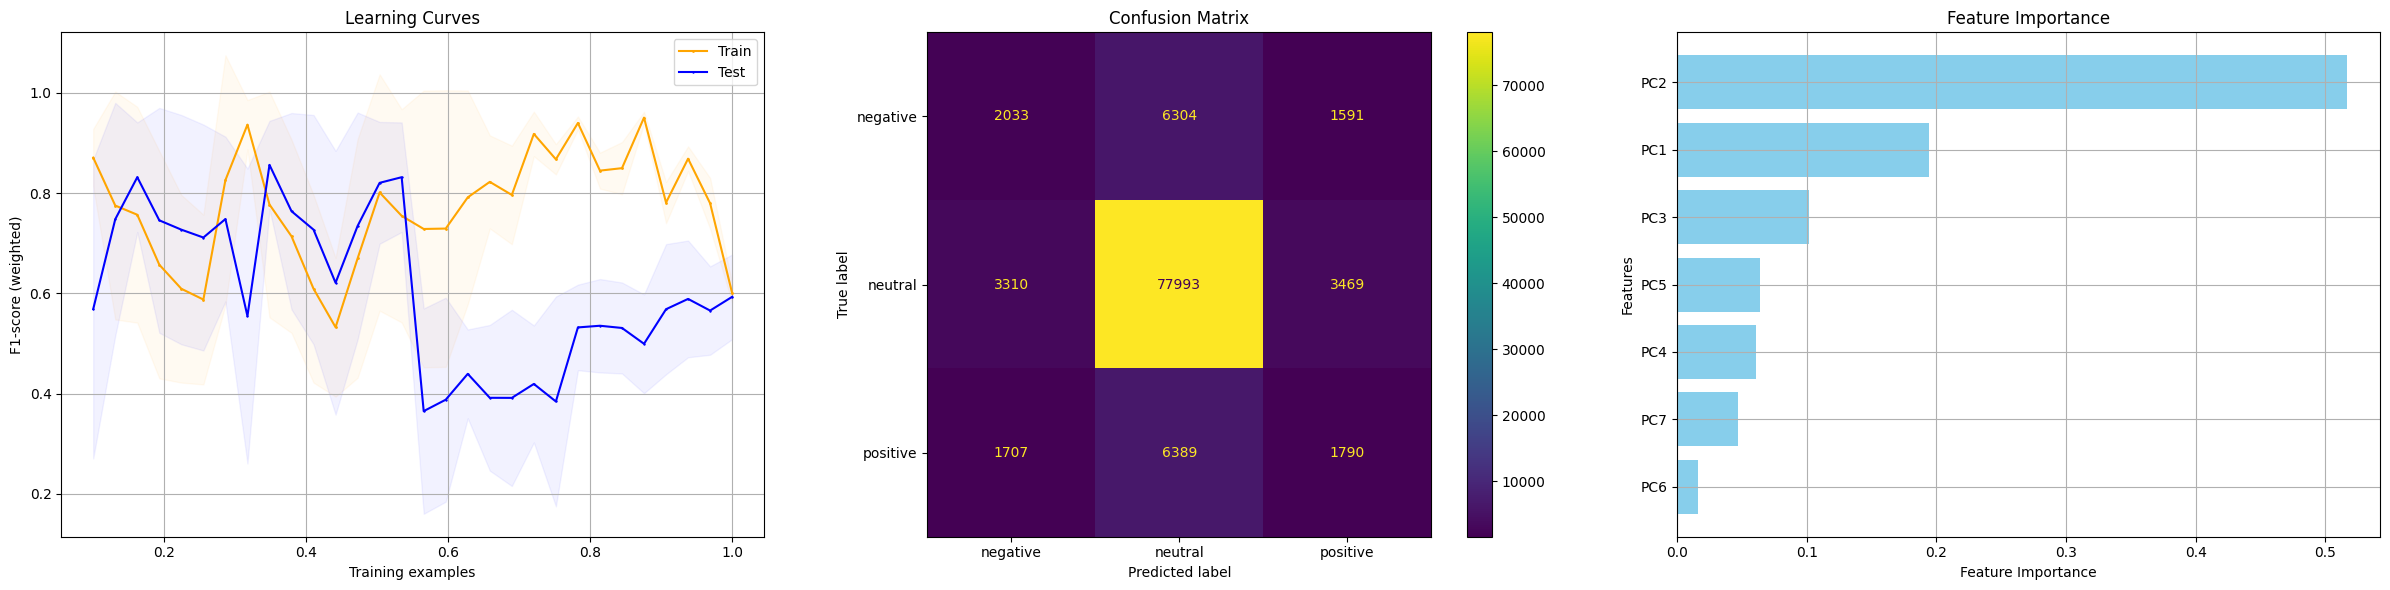

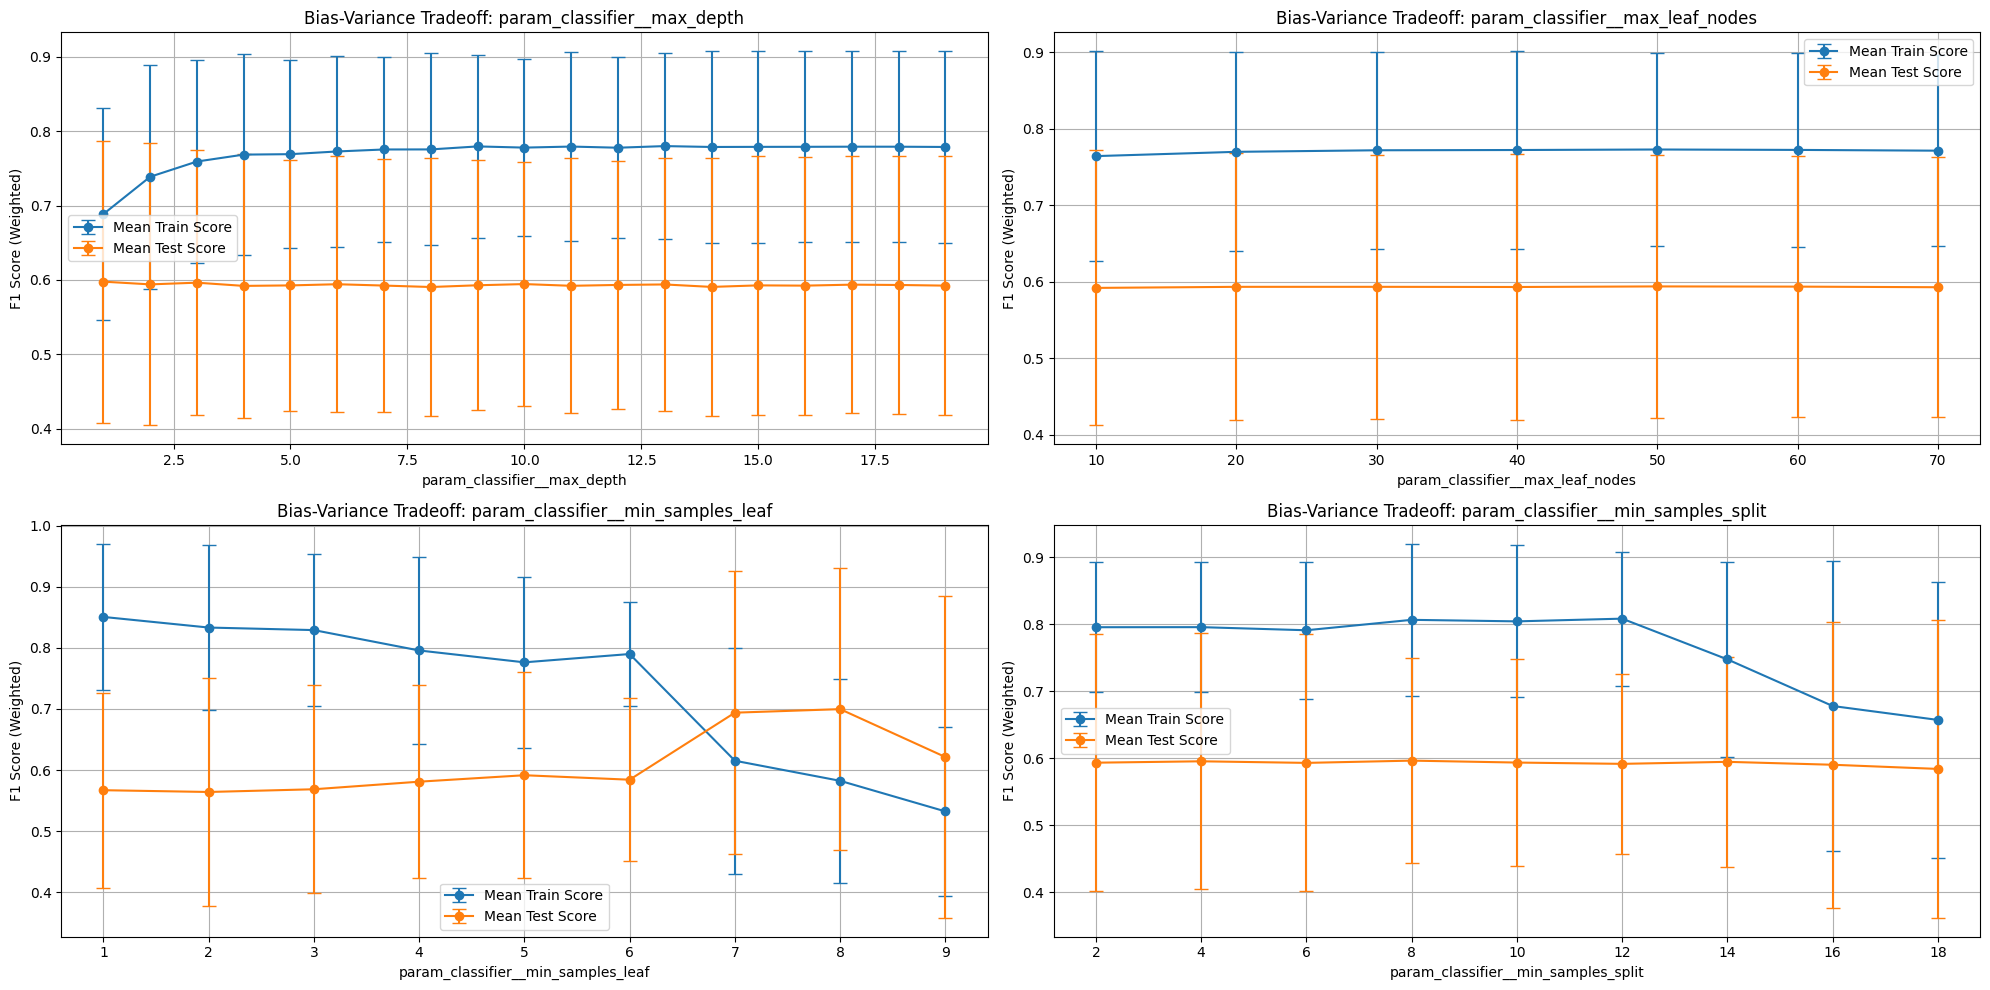


Best params for RFC_balanced_subsample model for BINANCE - orderbook
{'classifier__max_depth': 13, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 14}


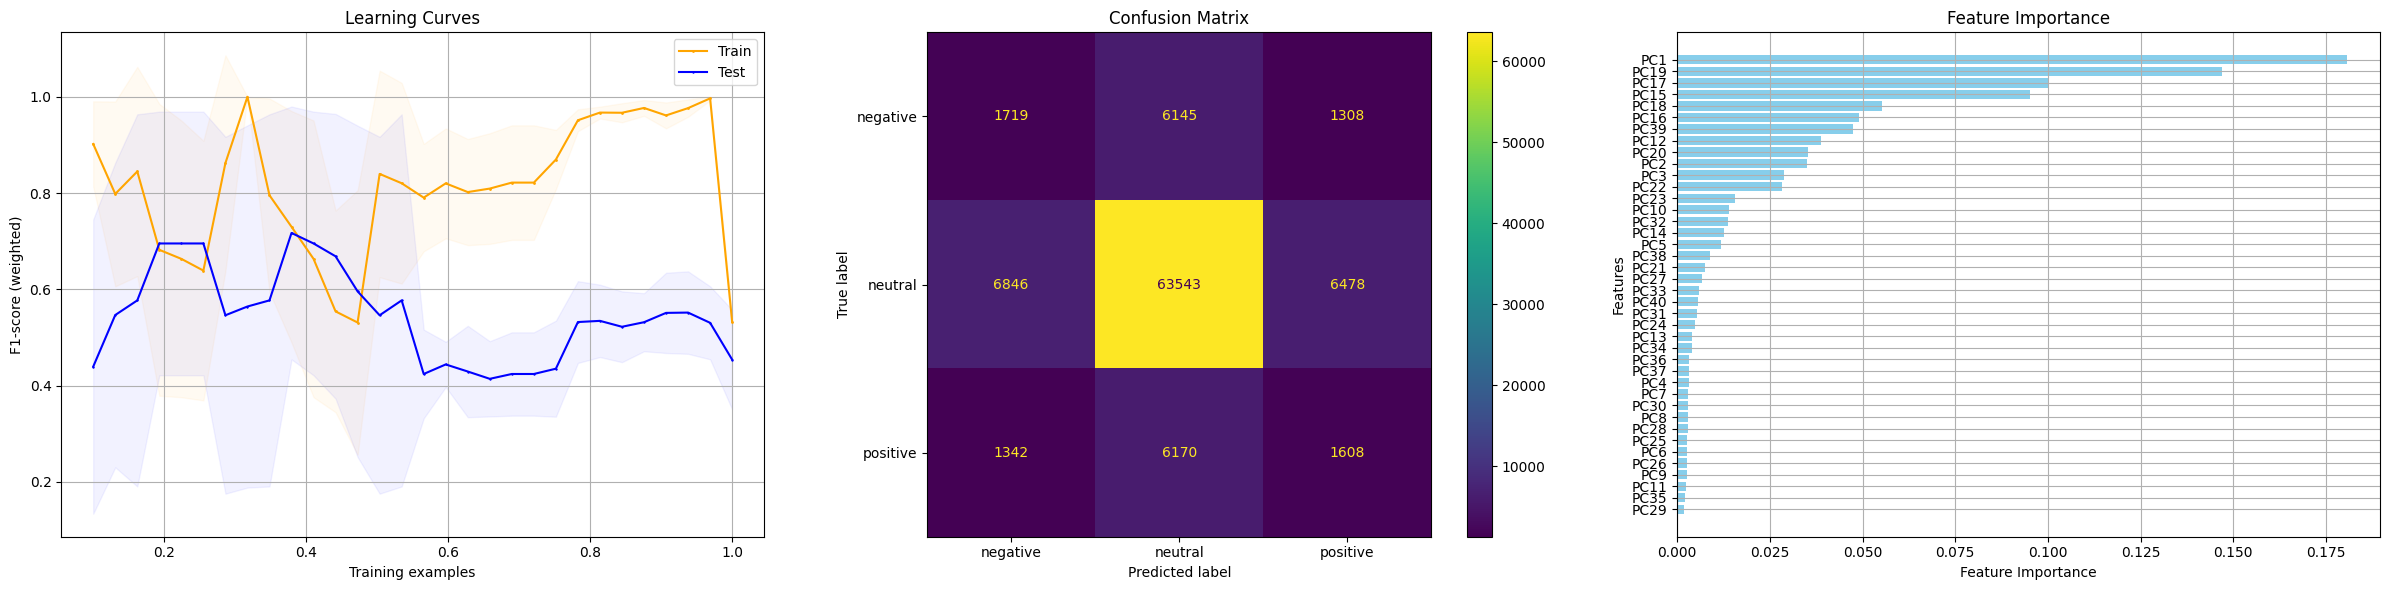

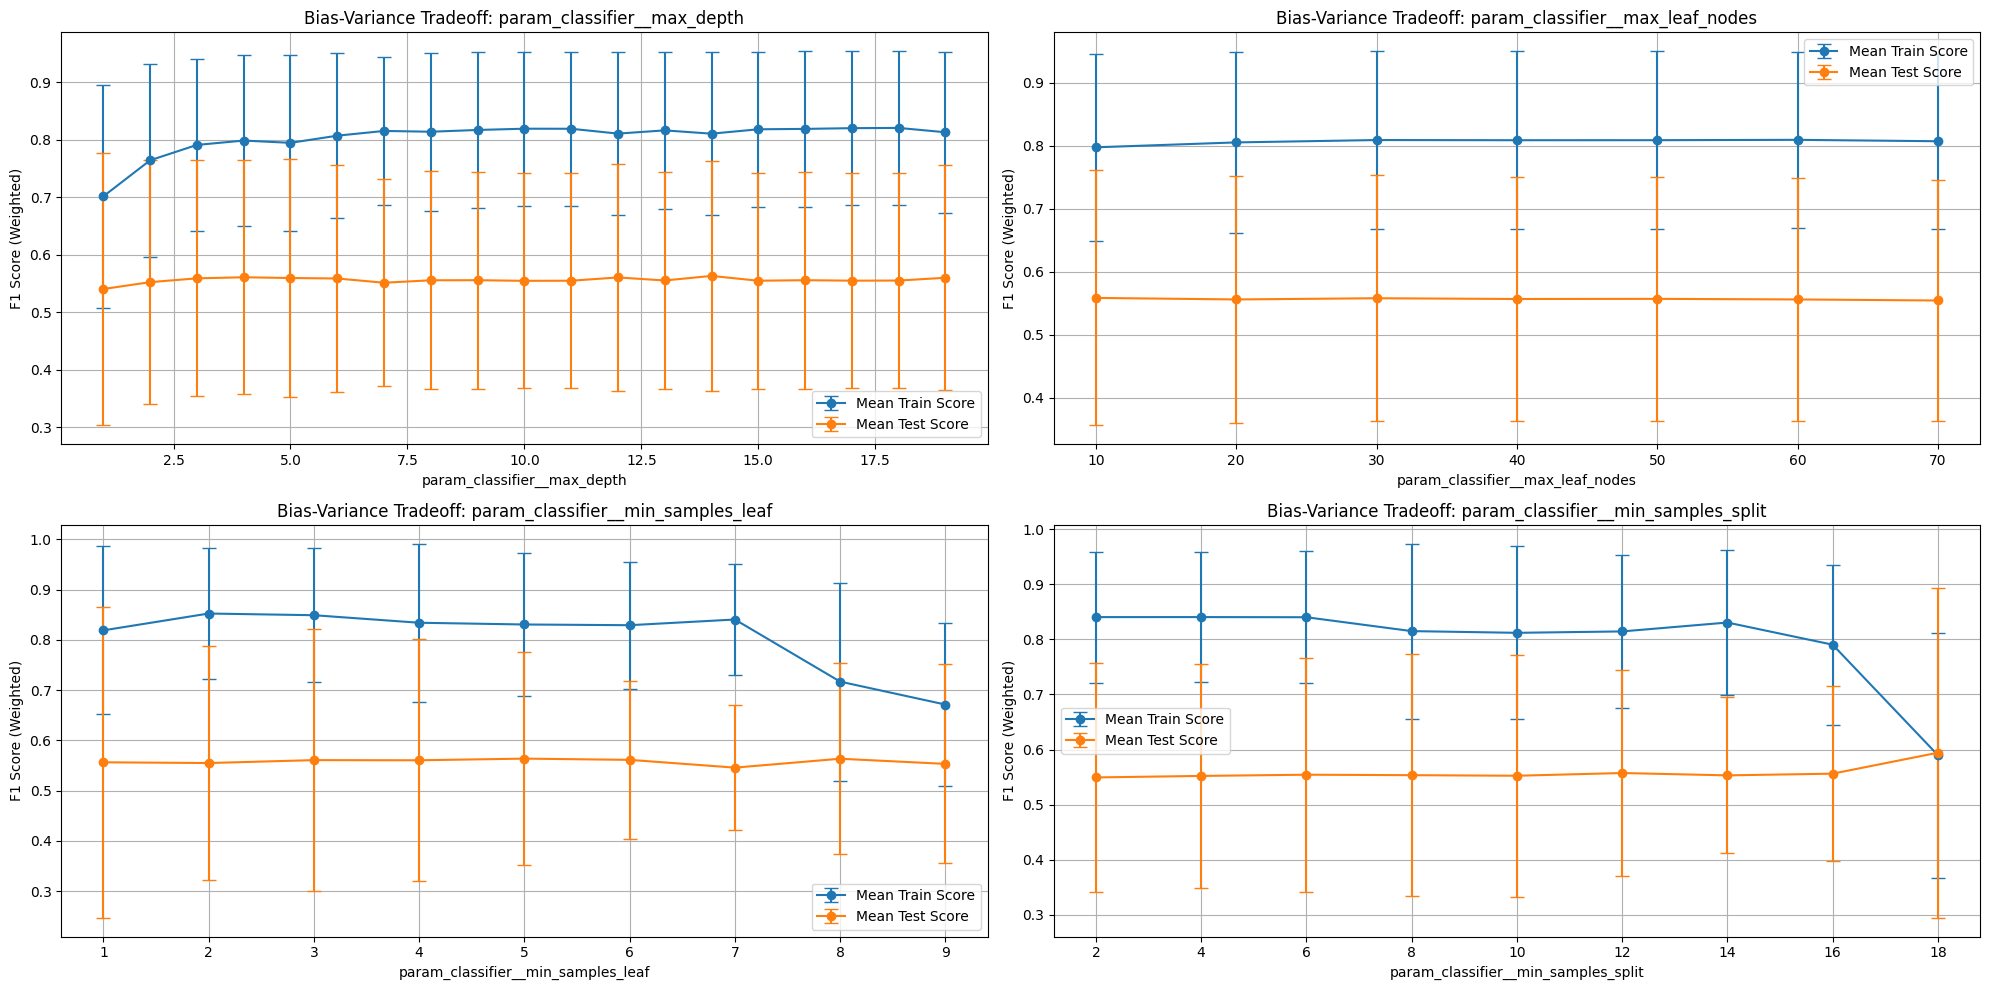


Best params for RFC_balanced_subsample model for BINANCE - unified
{'classifier__max_depth': 6, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4}


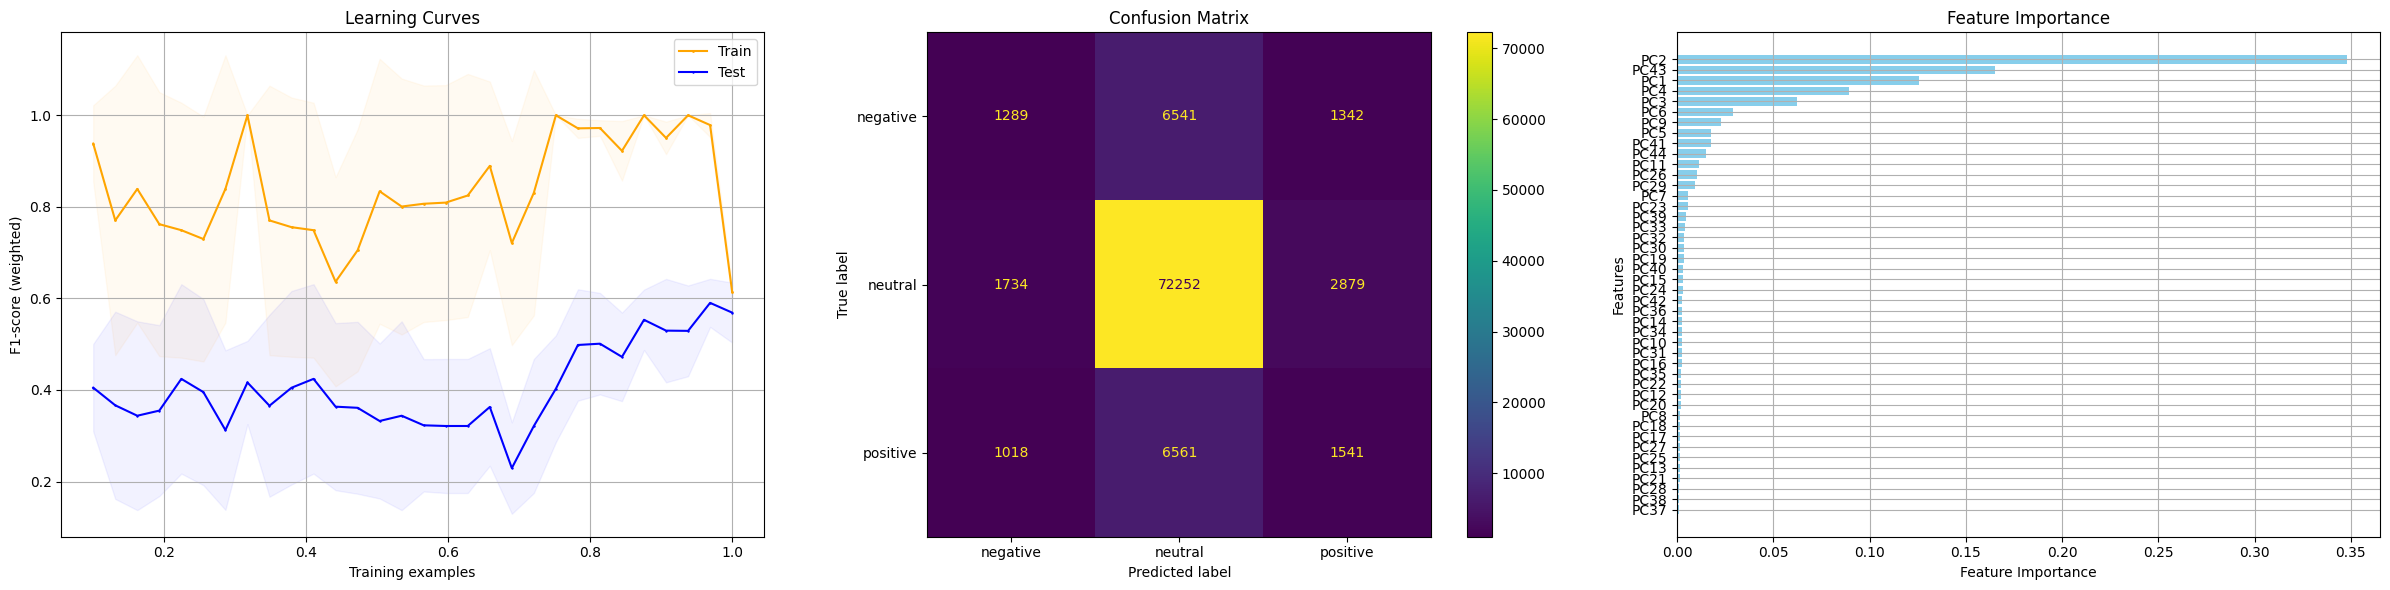

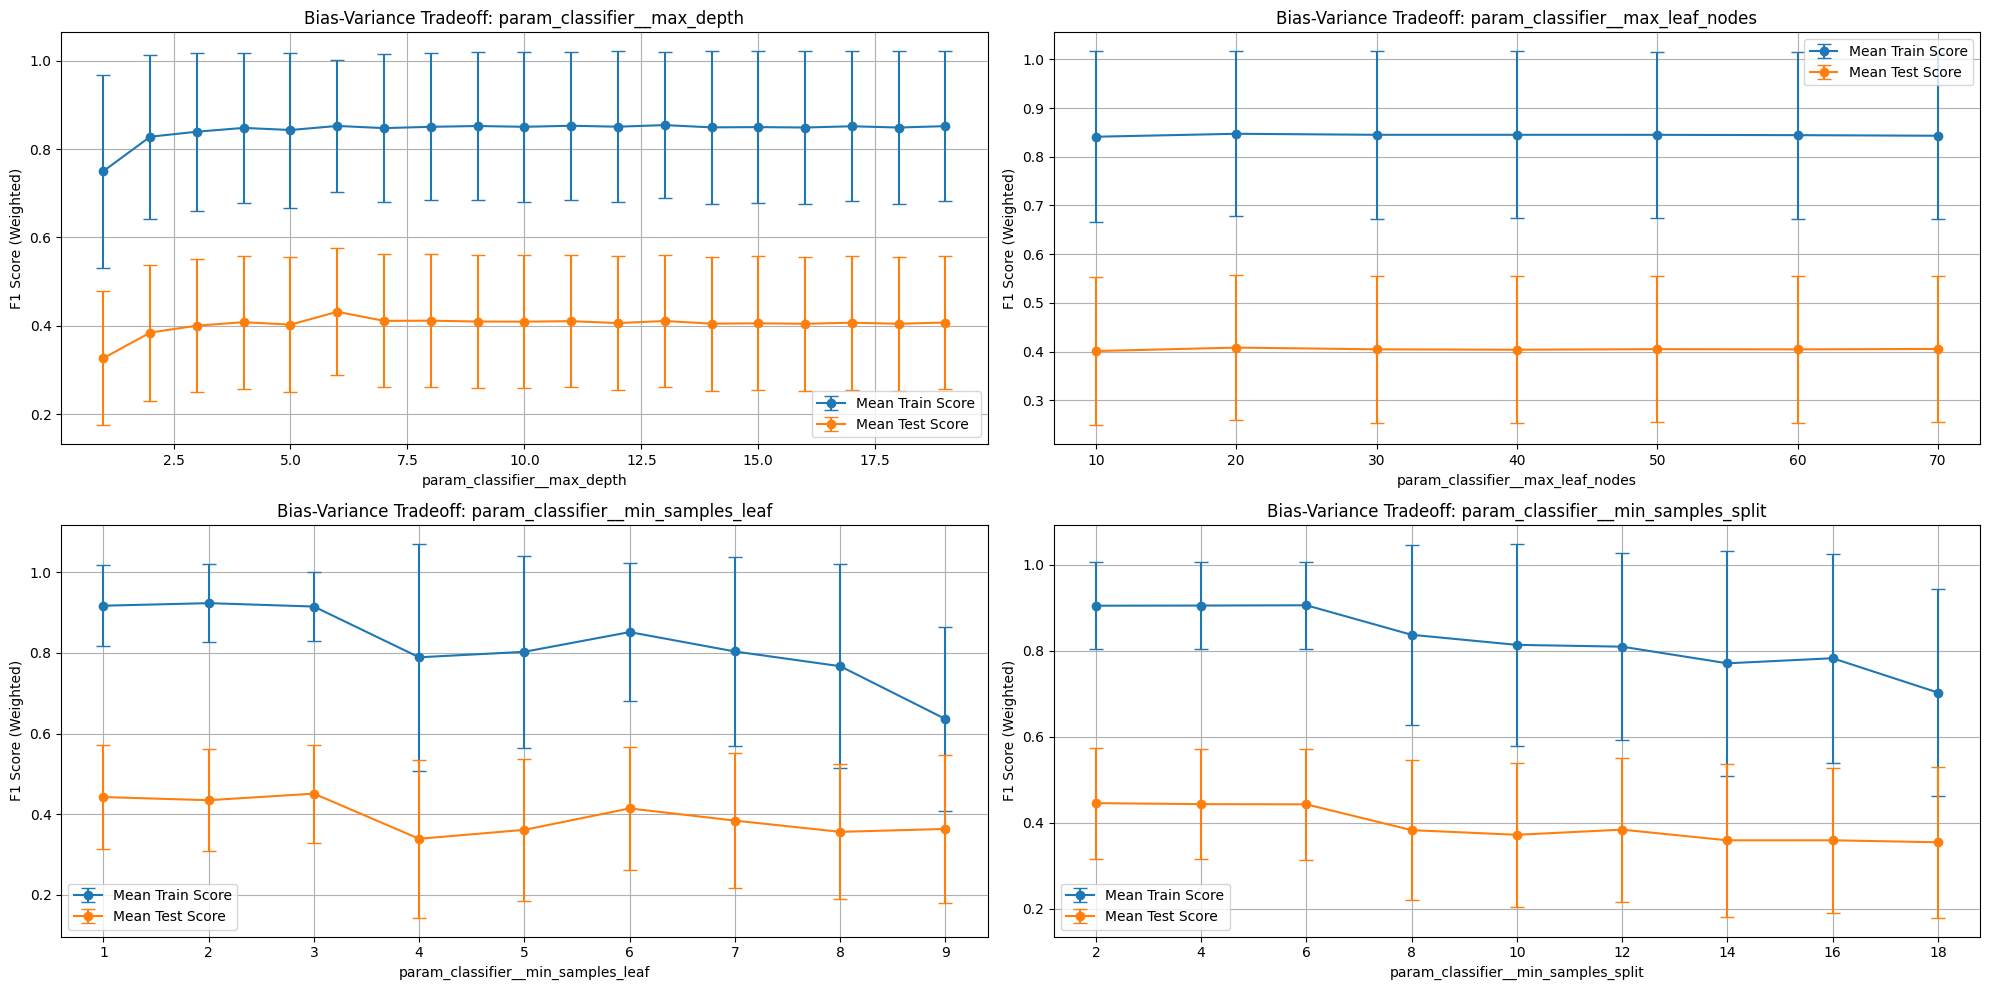


Best params for RFC_balanced_subsample model for HUOBI - candles
{'classifier__max_depth': 8, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


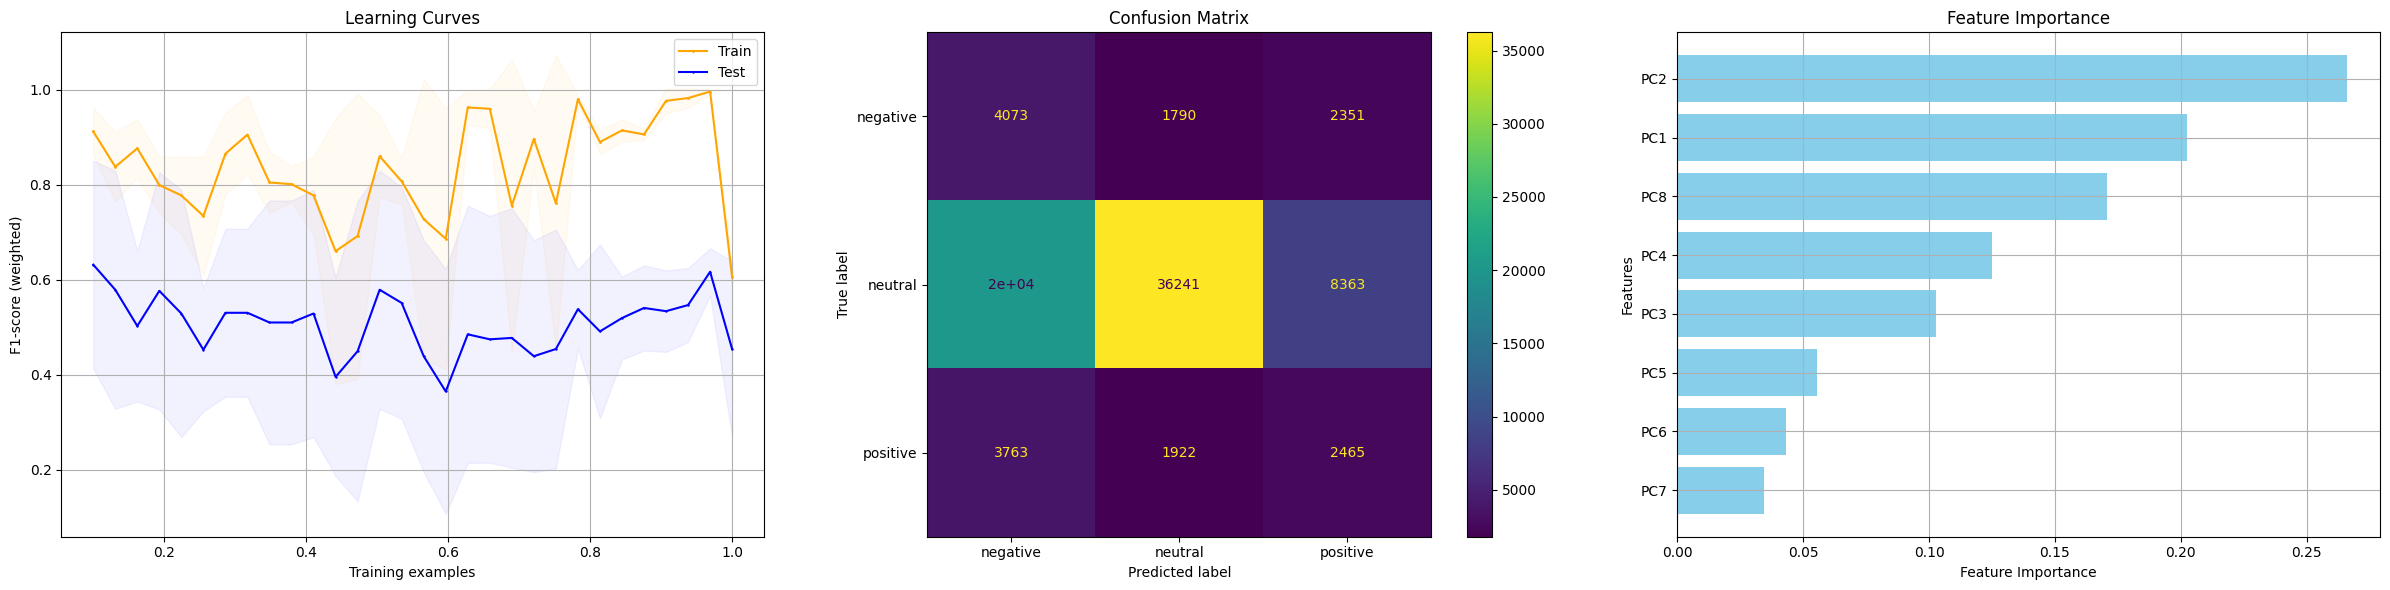

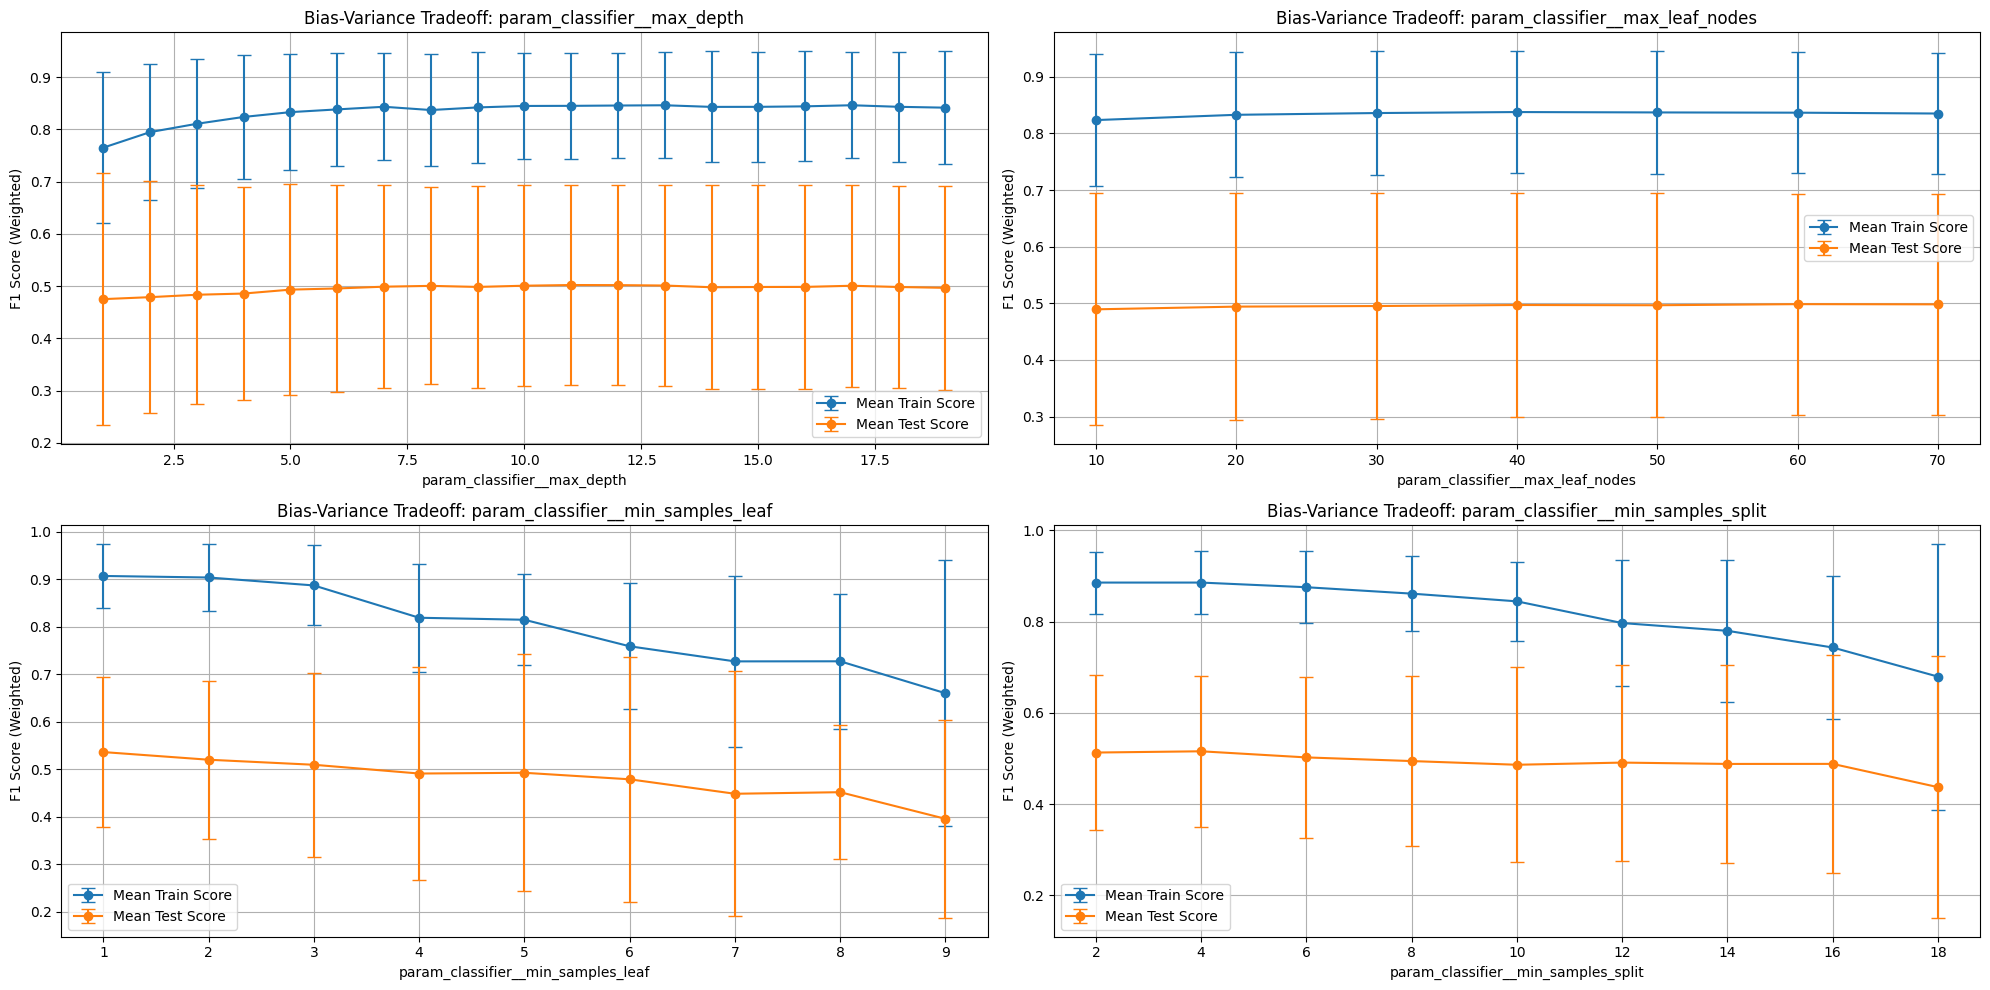


Best params for RFC_balanced_subsample model for HUOBI - orderbook
{'classifier__max_depth': 19, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 16}


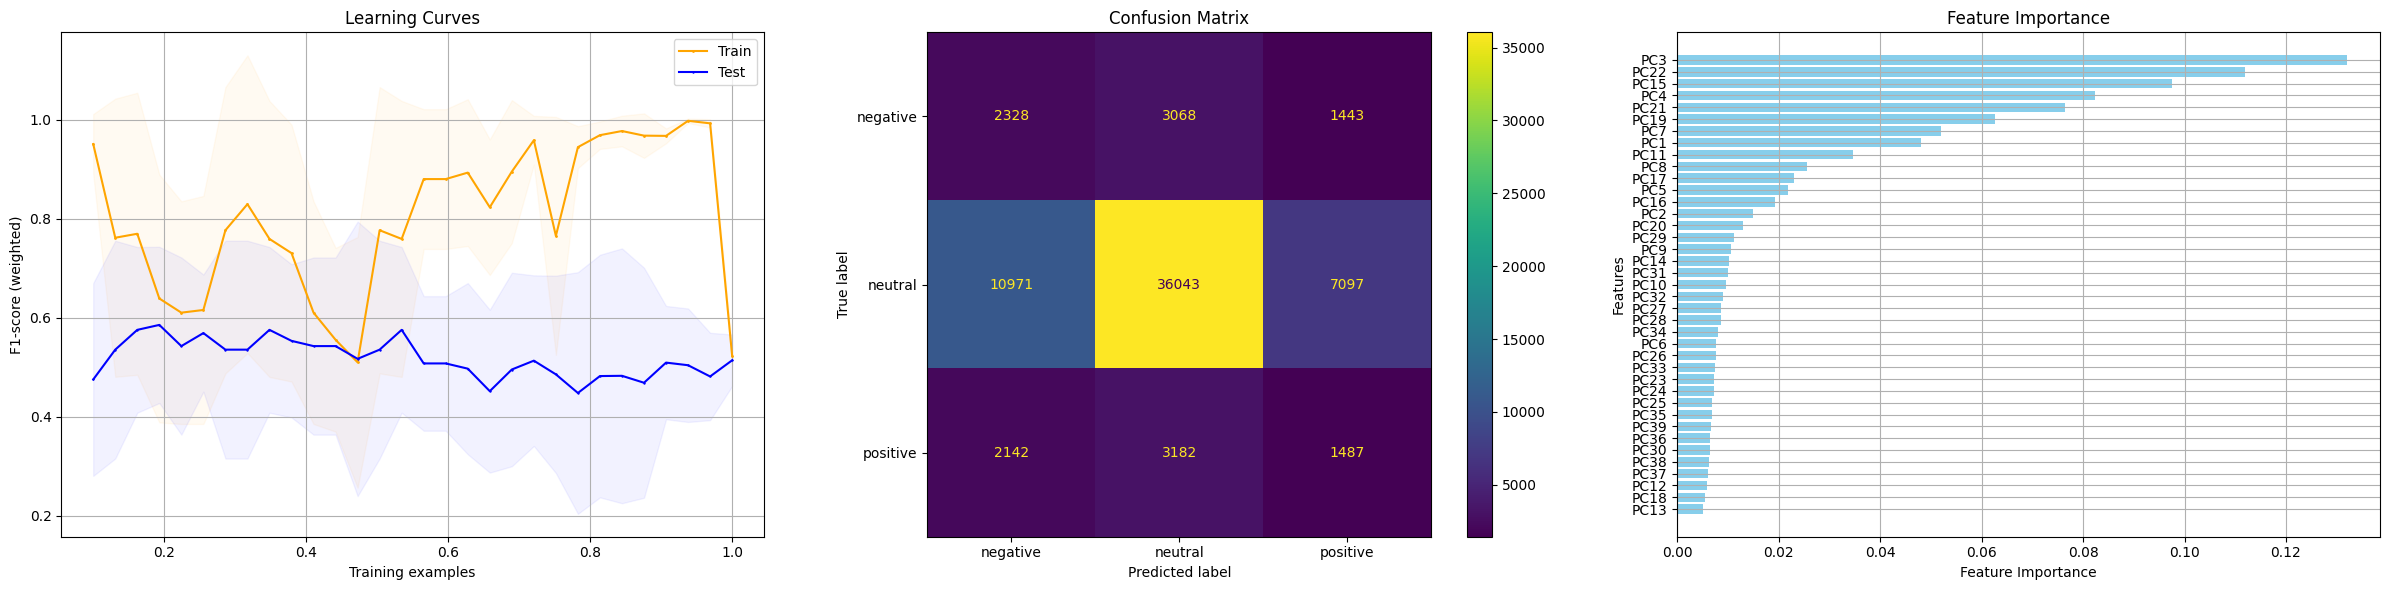

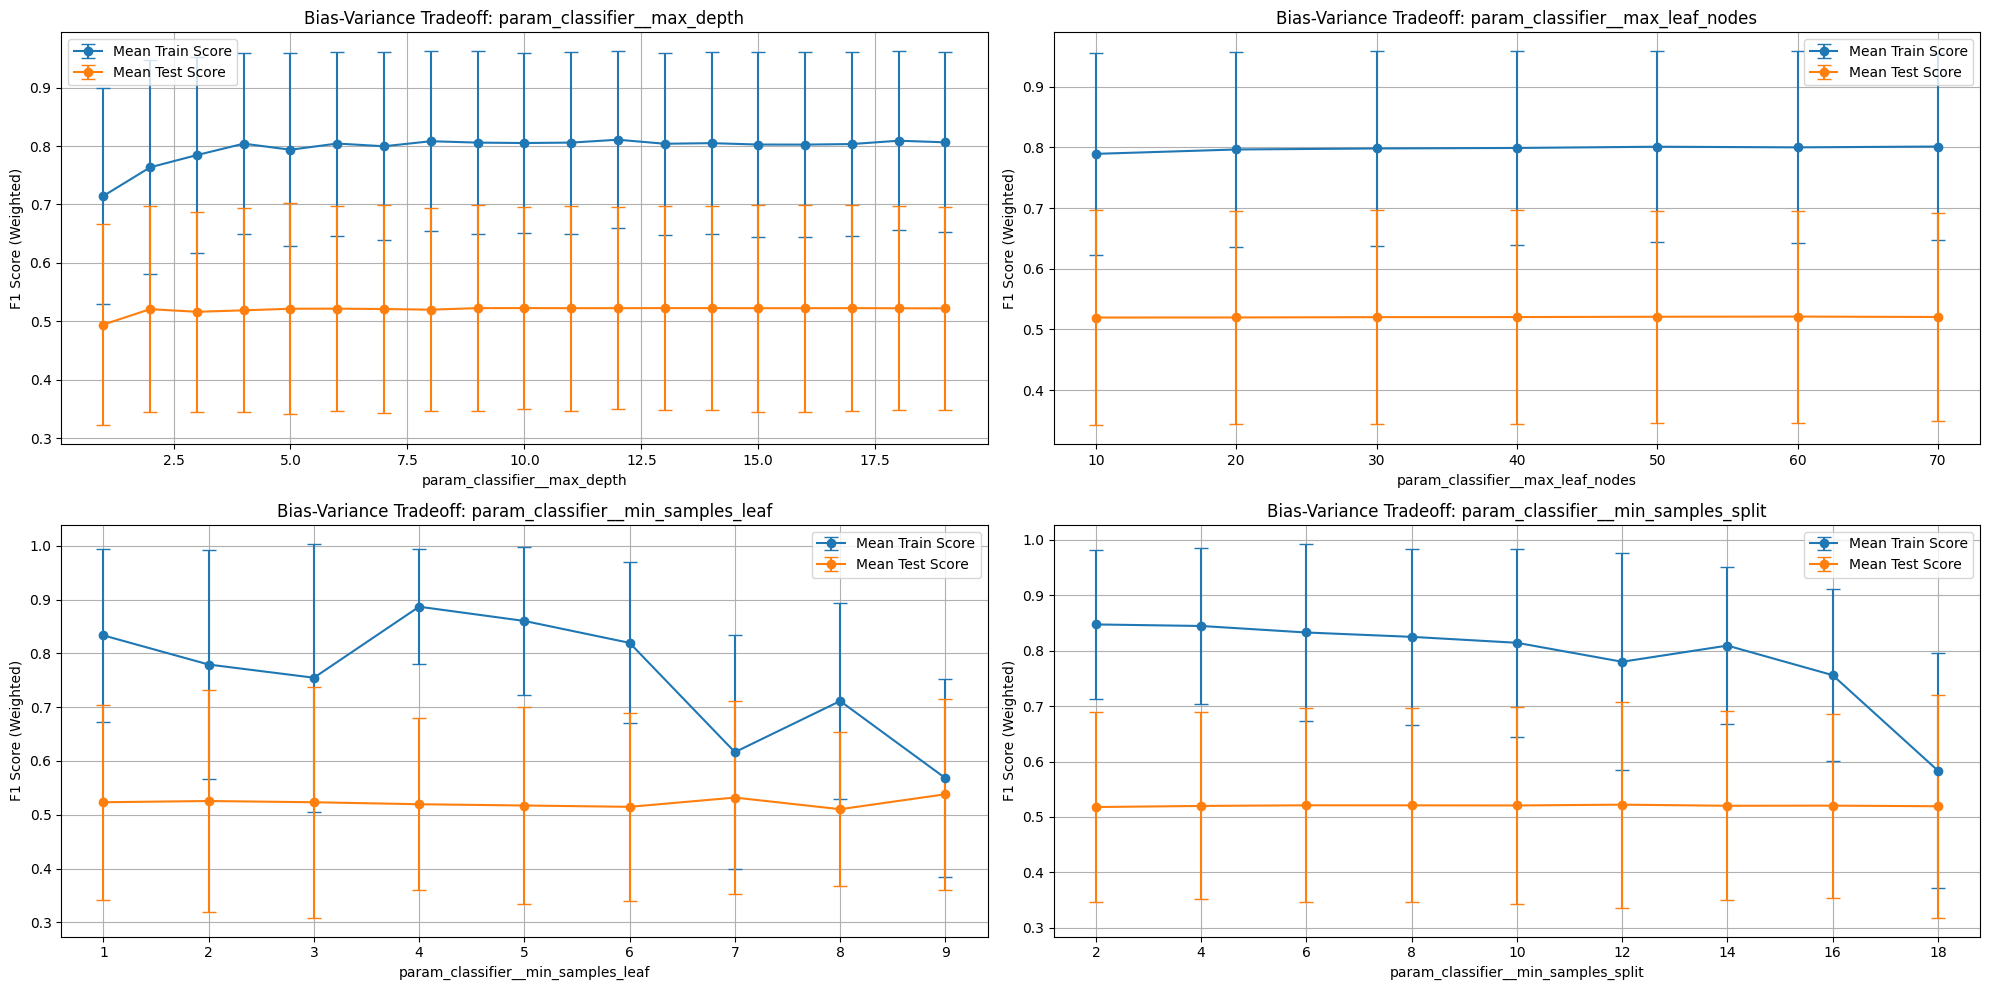


Best params for RFC_balanced_subsample model for HUOBI - unified
{'classifier__max_depth': 13, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 16}


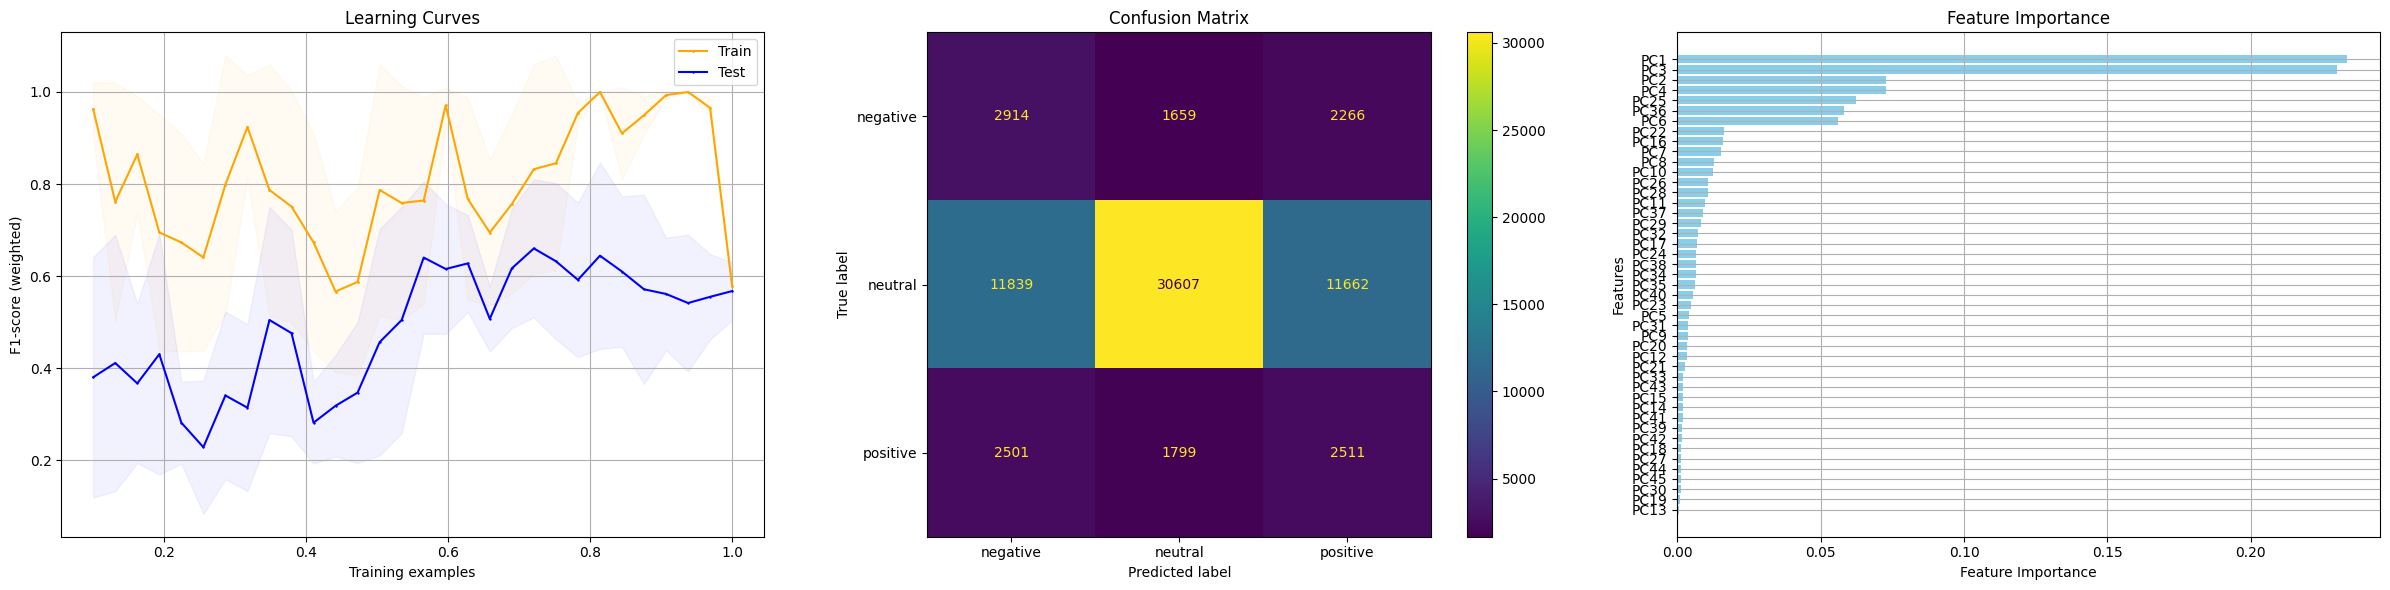

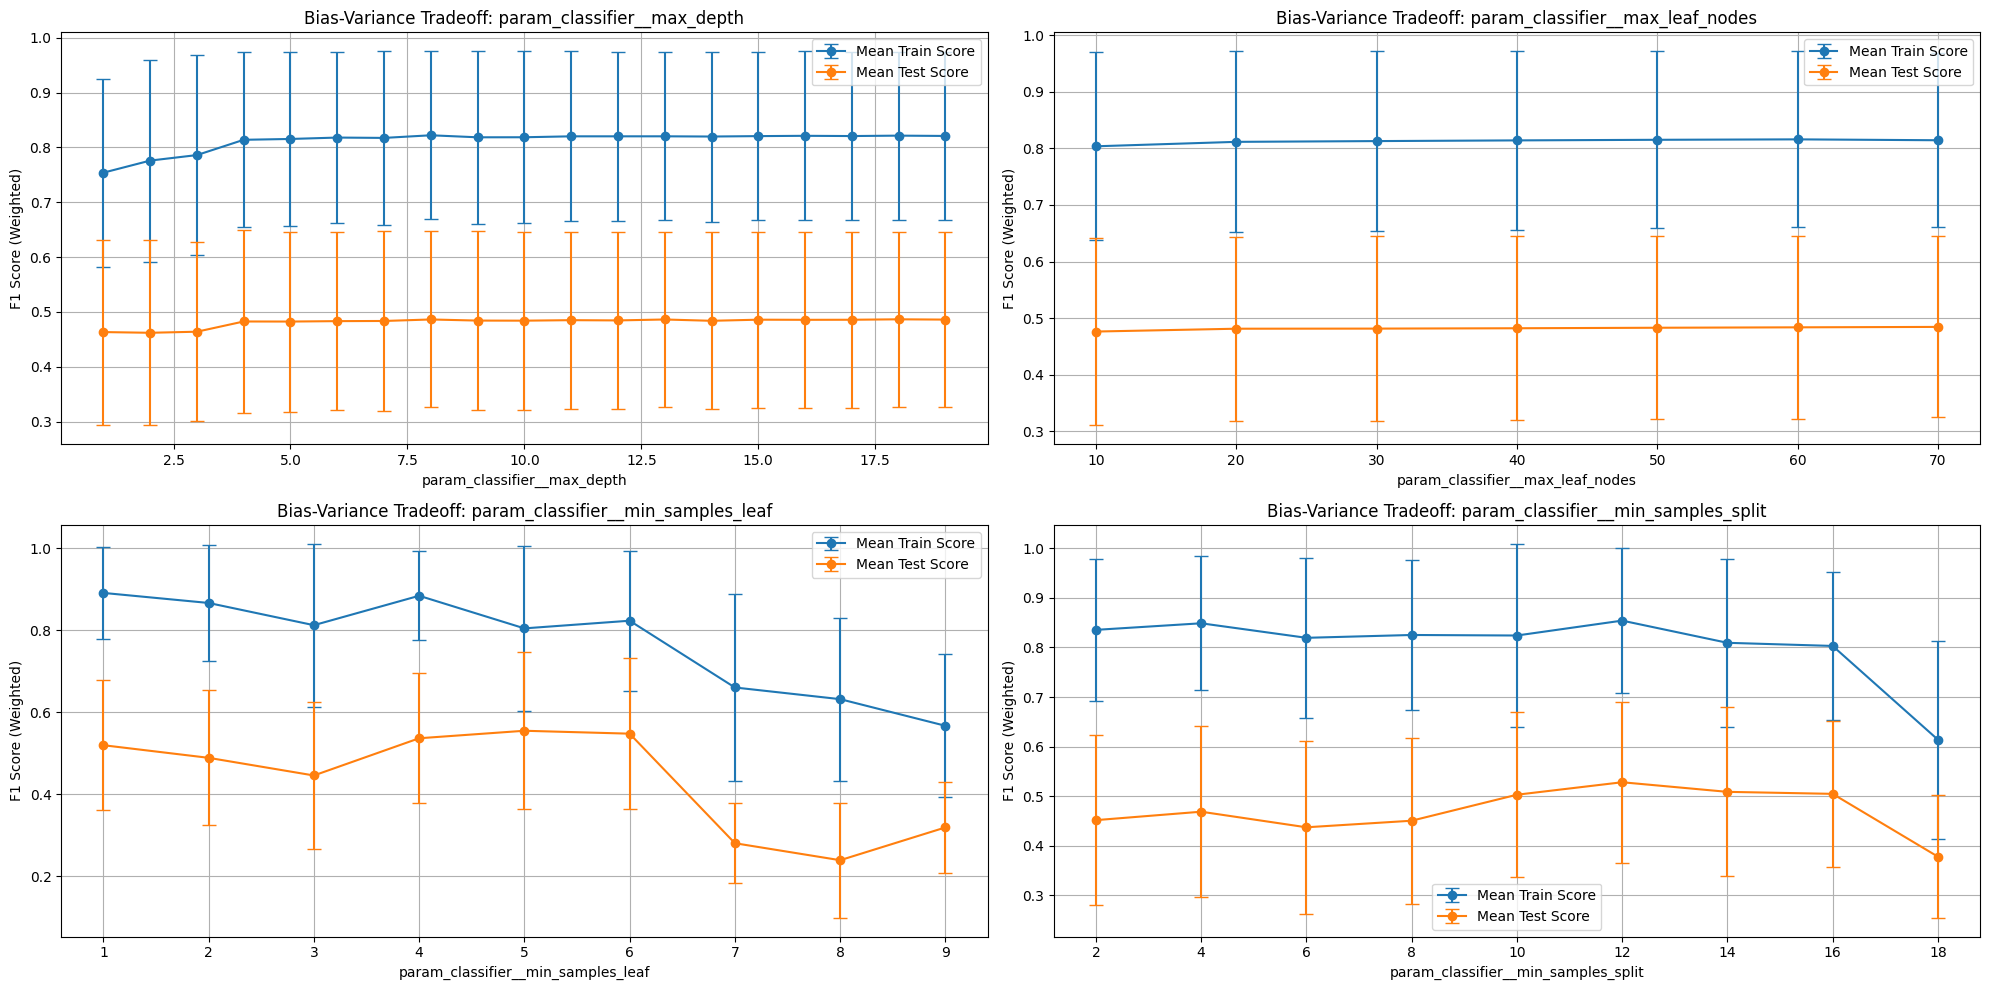


Best params for RFC_balanced_subsample model for OKX - candles
{'classifier__max_depth': 9, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4}


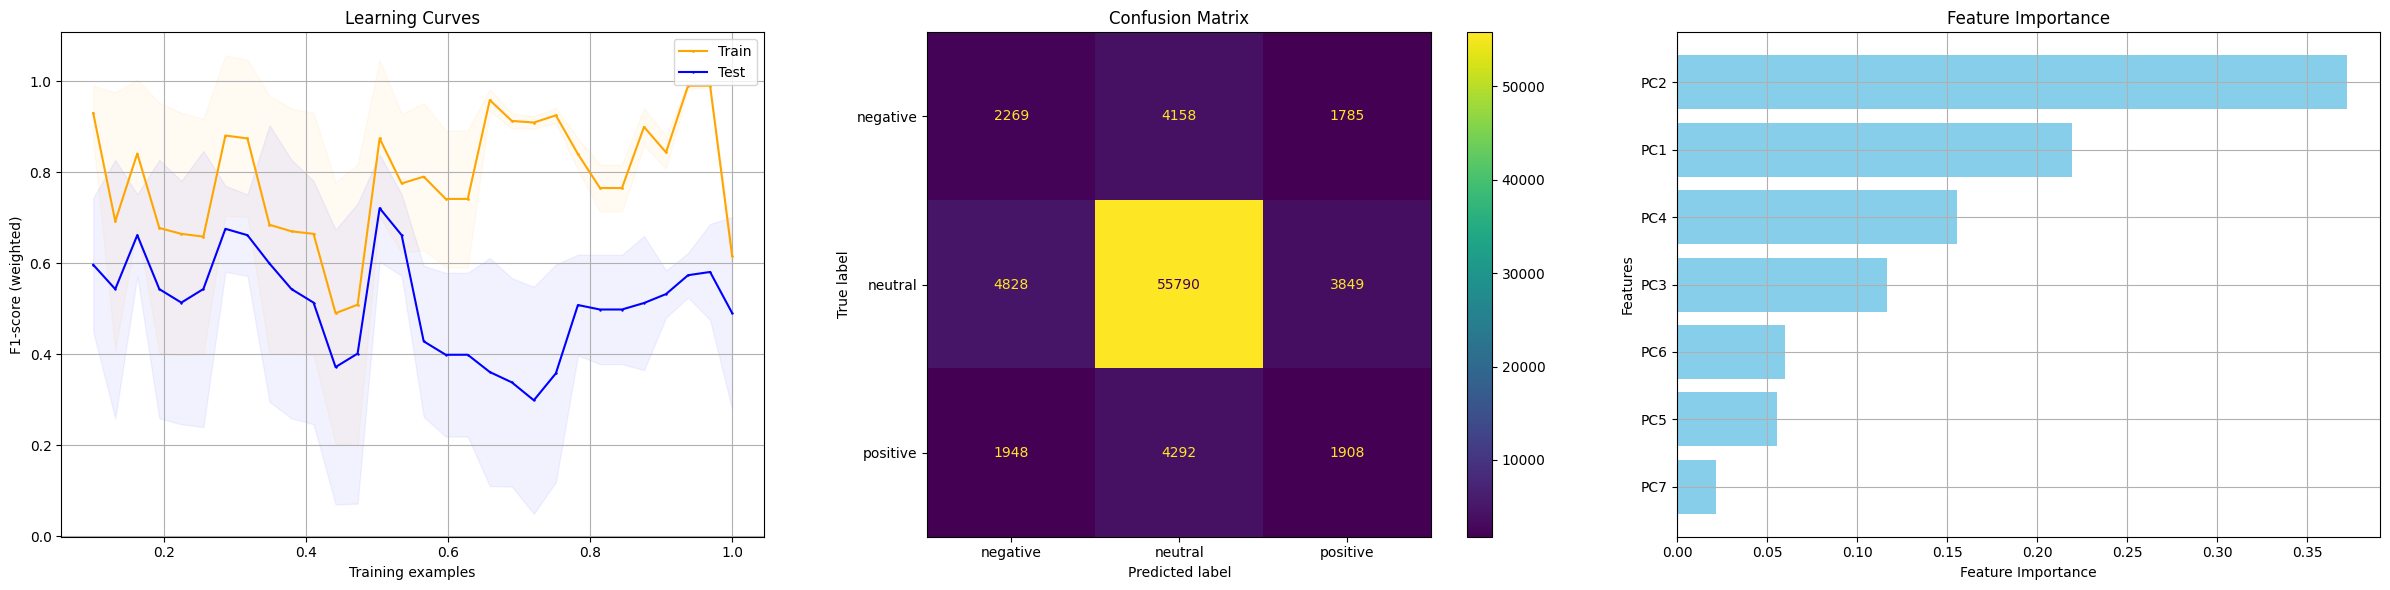

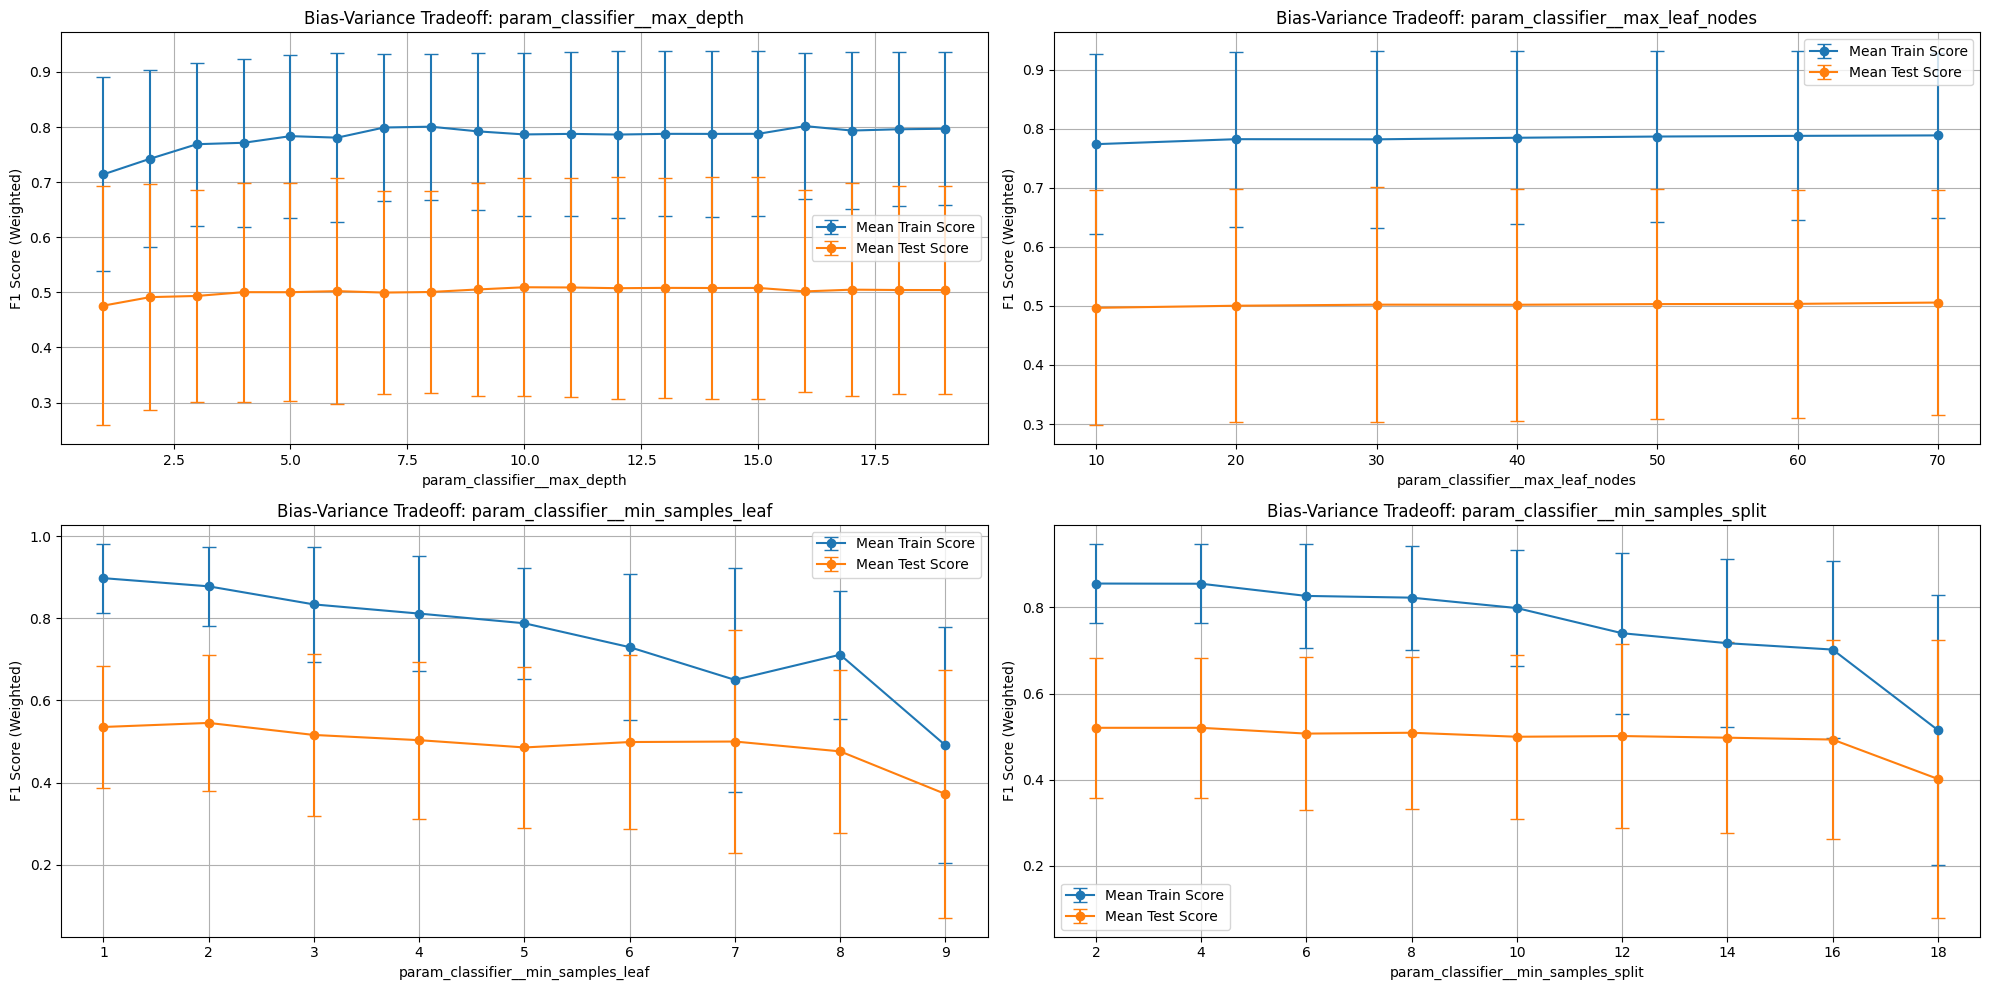


Best params for RFC_balanced_subsample model for OKX - orderbook
{'classifier__max_depth': 15, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 14}


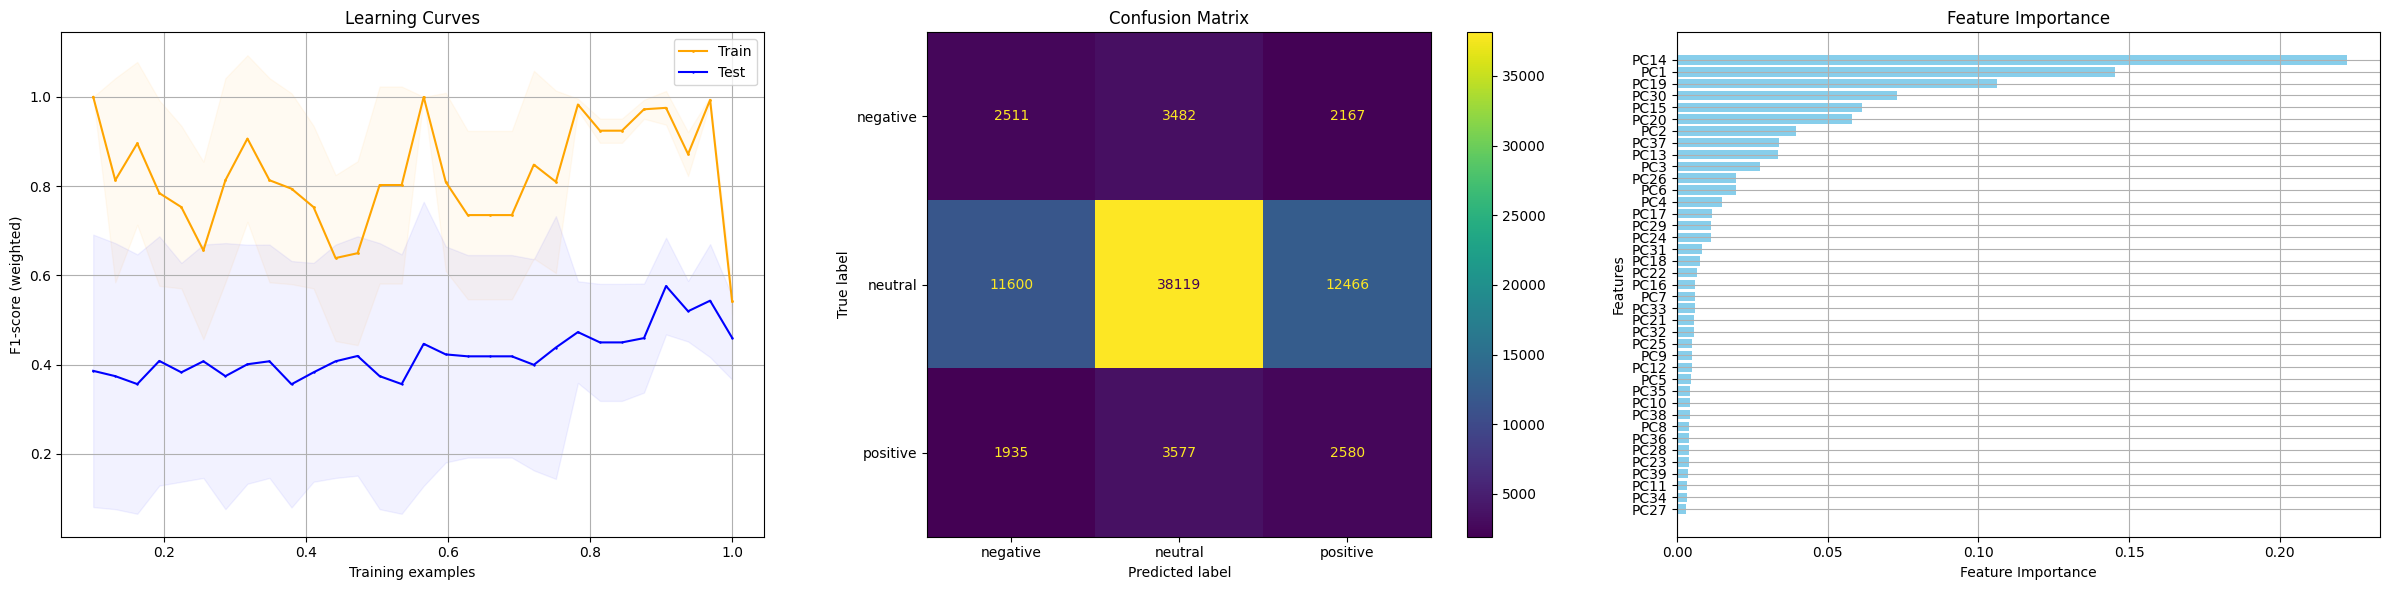

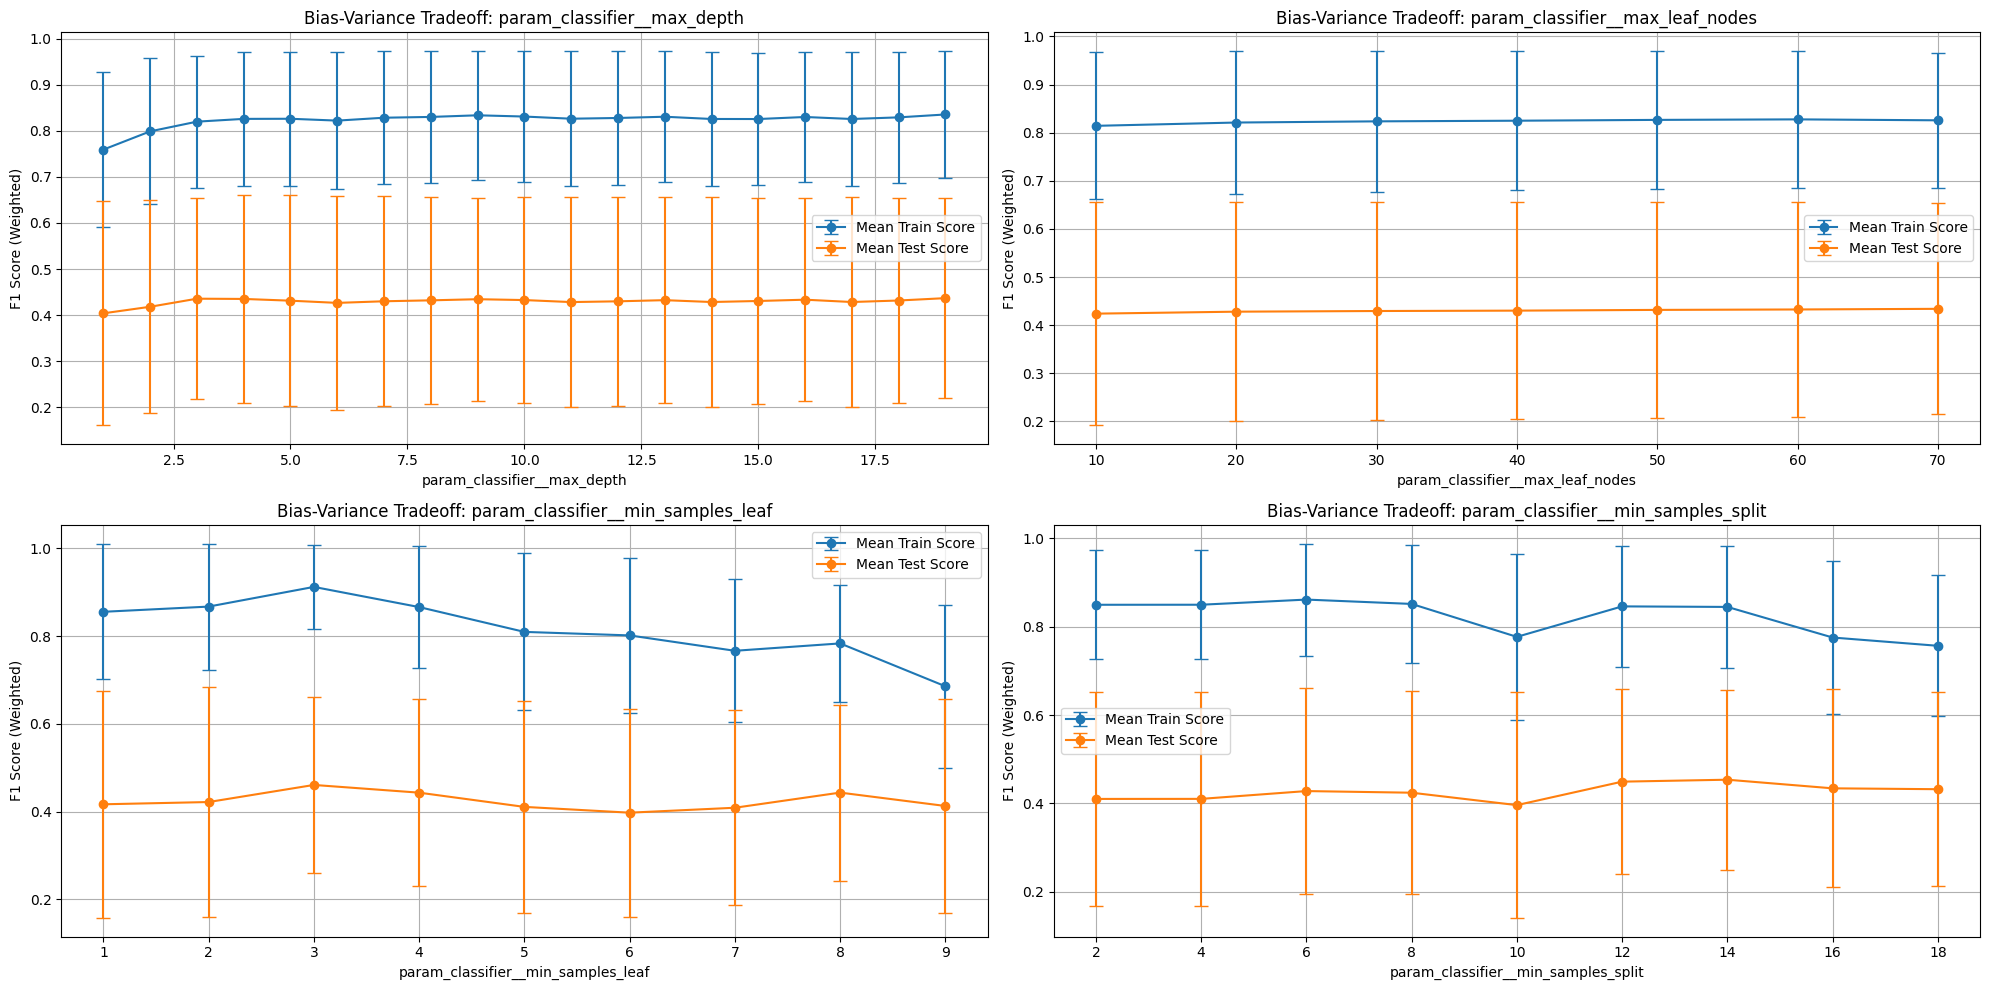


Best params for RFC_balanced_subsample model for OKX - unified
{'classifier__max_depth': 19, 'classifier__max_leaf_nodes': 70, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 14}


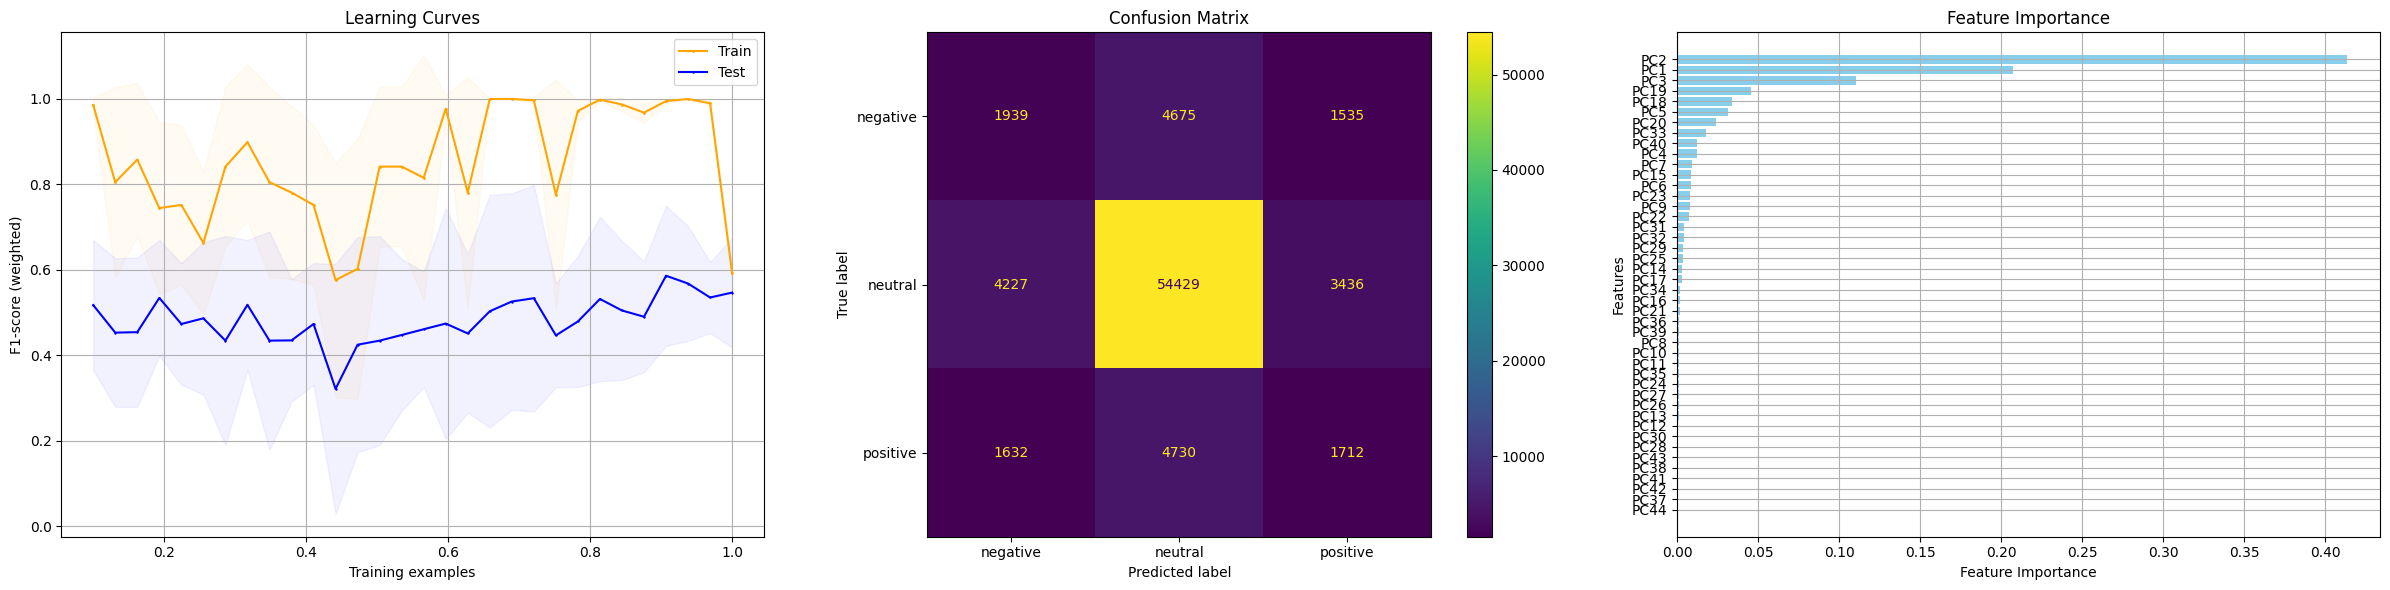

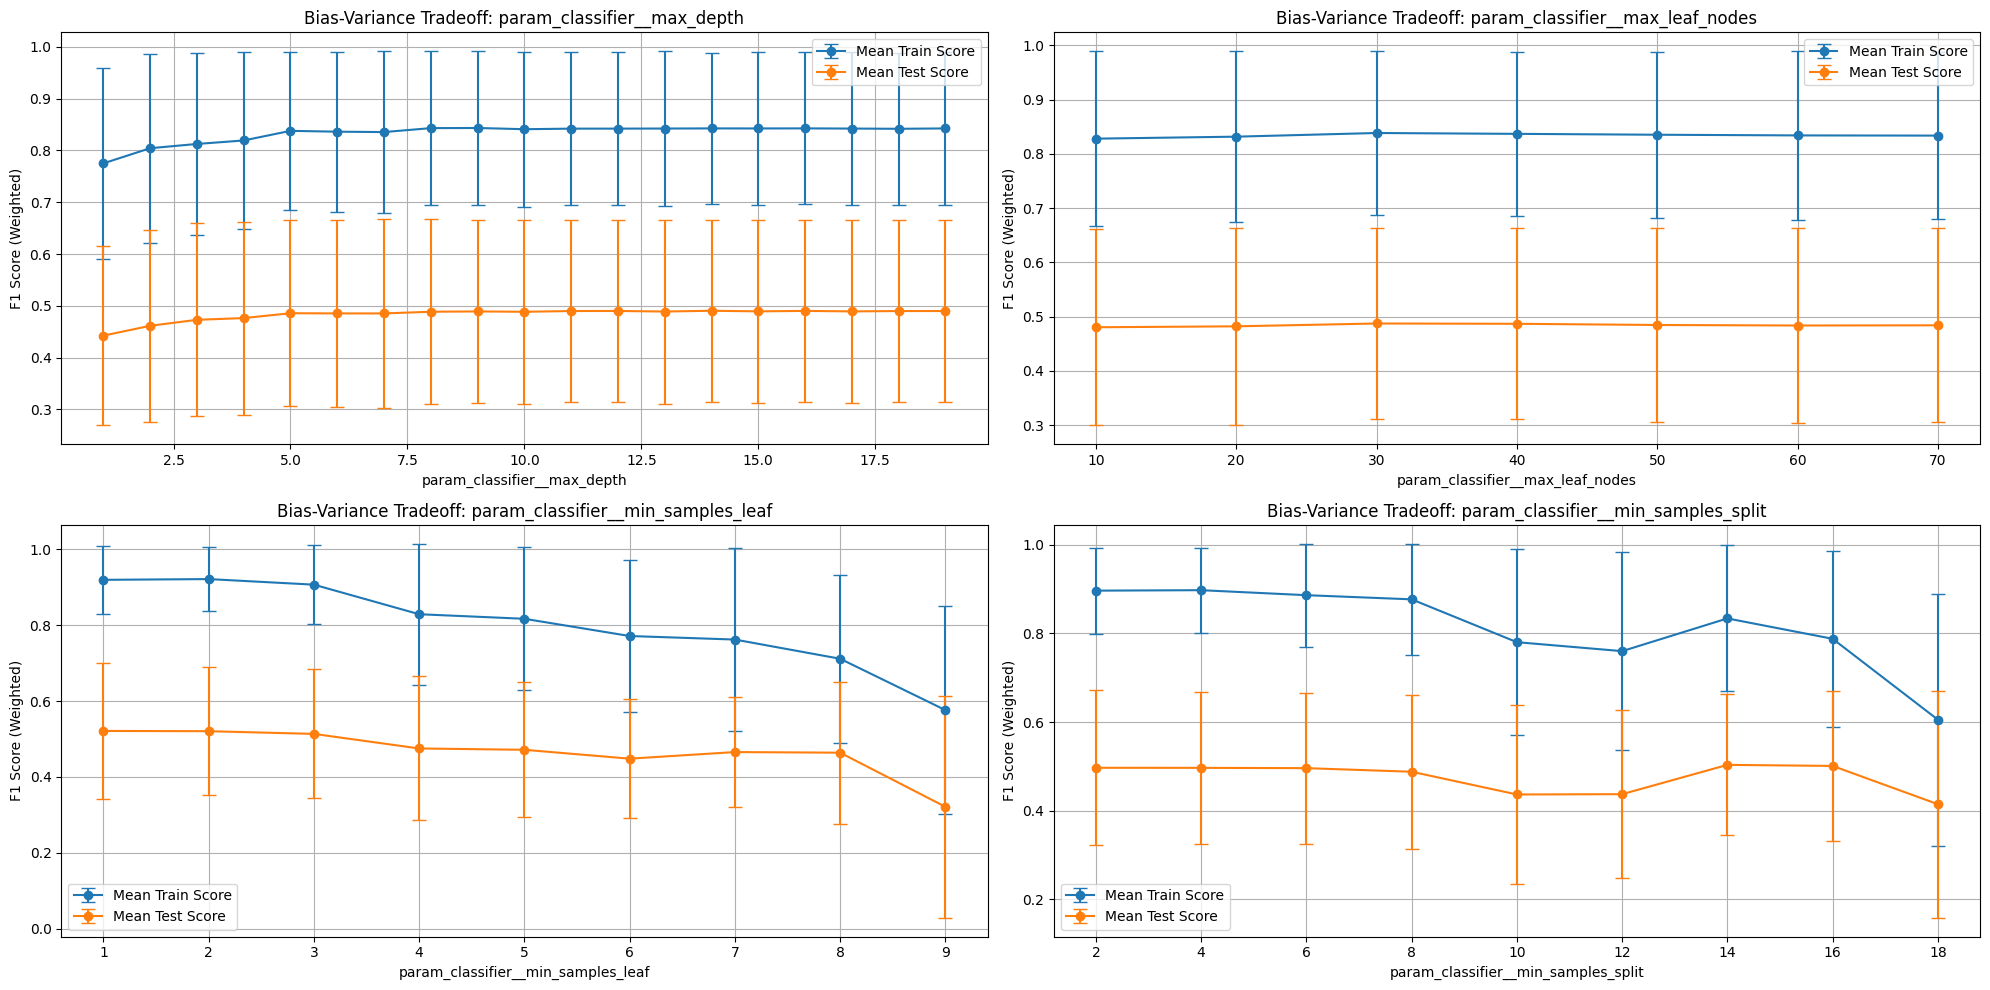


Best params for RFC_balanced_subsample model for ALL - unified
{'classifier__max_depth': 17, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 8}


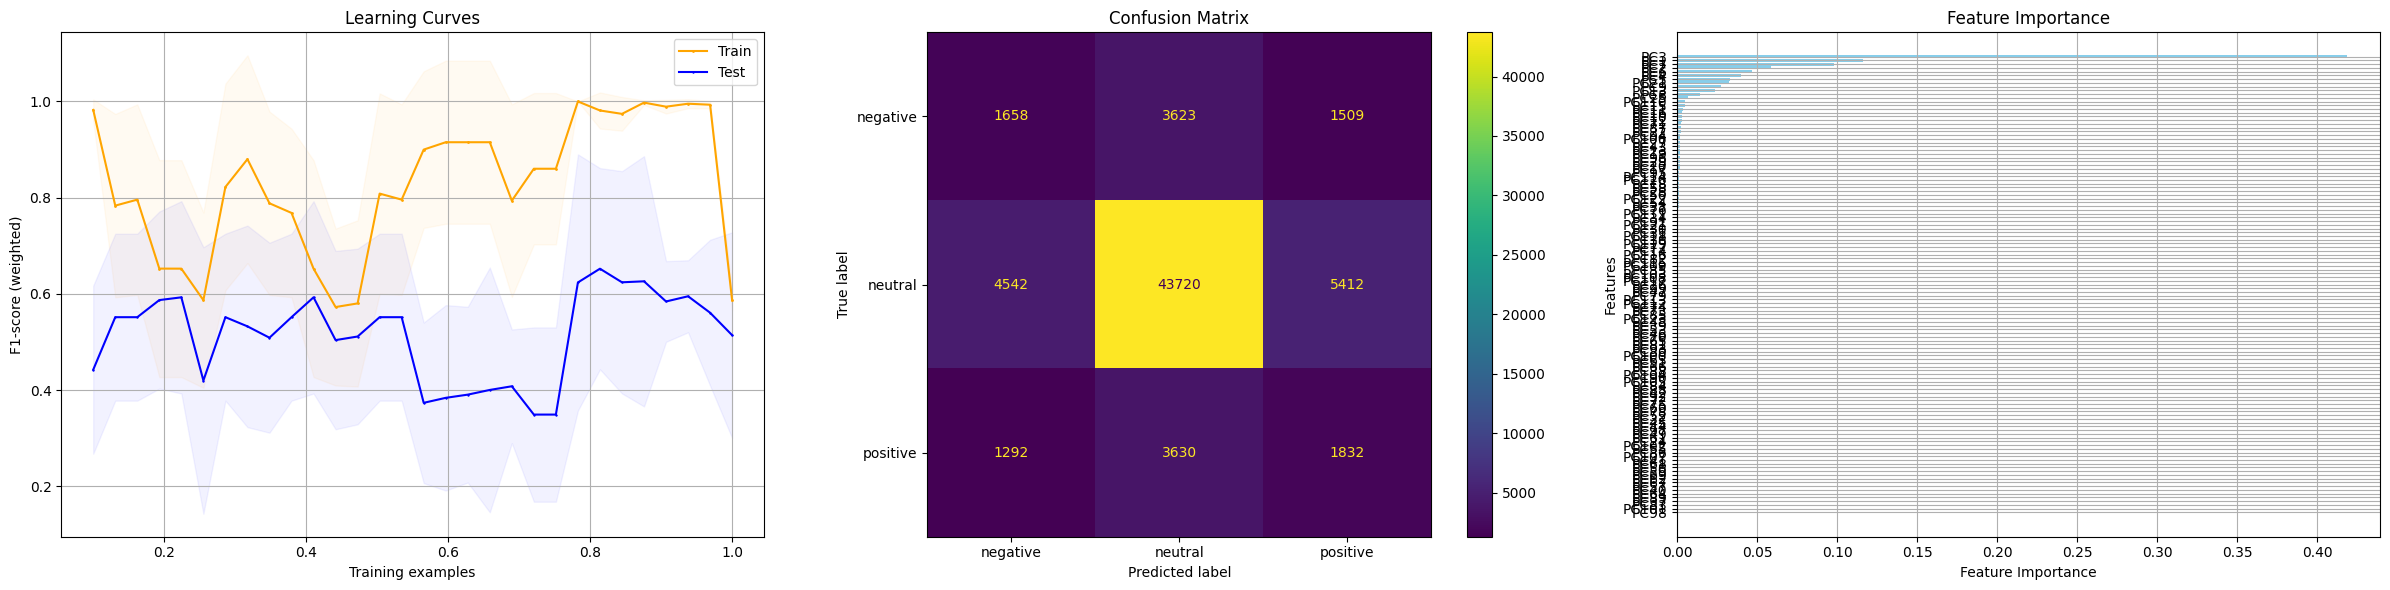

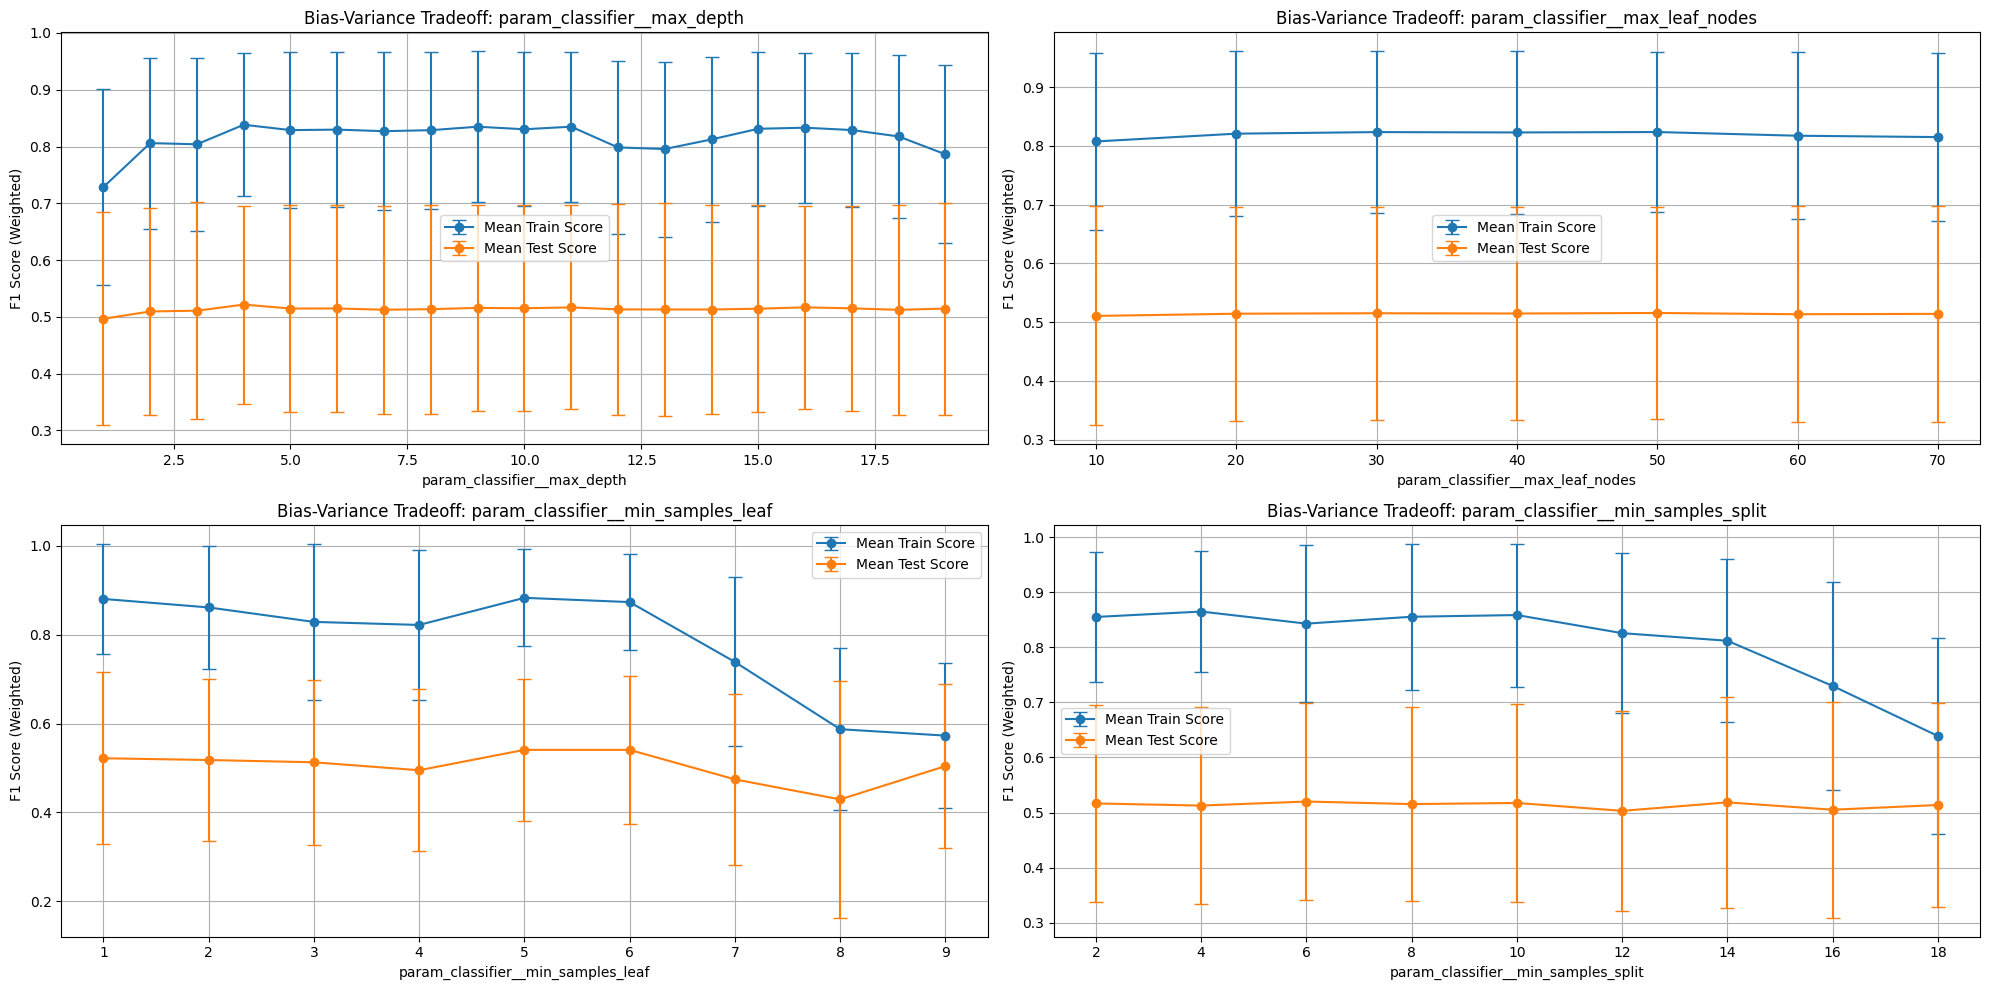

In [17]:
# Evaluation

for classifier_name, _ in classifiers.items():
        for exchange, data_type in product(ALL_MODELS, DATA_TYPES):
                model_path = os.path.join(MODELS_DATA_PATH, f"{classifier_name}_{exchange}_{data_type}.pkl")
                
                if not os.path.exists(model_path):
                    continue

                with open(model_path, "rb") as model_file:
                    btcf = pickle.load(model_file)

                btcf.evaluate()

                save_model(btcf, classifier_name, exchange, data_type)
                
                print(f"\nBest params for {classifier_name} model for {exchange} - {data_type}")
                print(btcf.results['best_params'])
                
                # Plots
                filename_prefix = f"{classifier_name}_{exchange}_{data_type}"
                val_curve_param = 'classifier__max_depth'

                btcf.plot_learn_cm_feat(f"{filename_prefix}_learn_val_feat.png")
                btcf.plot_bias_variance_tradeoff(f"{filename_prefix}_bias_variance_tradeoff.png")

In [18]:
# Reading results

eval_results = []
t_test_data = []
comparison_data = []
t_test_metrics = ['mean_test_score']

for classifier_name, _ in classifiers.items():
    for exchange, data_type in product(ALL_MODELS, DATA_TYPES):
        model_path = os.path.join(MODELS_DATA_PATH, f"{classifier_name}_{exchange}_{data_type}.pkl")

        if not os.path.exists(model_path):
            continue

        with open(model_path, "rb") as model_file:
            btcf = pickle.load(model_file)

        # Common fields
        common_fields = {
            'classifier': classifier_name,
            'exchange': exchange,
            'data_type': data_type,
        }

        # Collect evaluation metrics
        eval_metrics = [x for x in btcf.results.keys() if x not in ['best_params', 'conf_matrix', 'cv_results', 'classification_report', 'feature_selection']]
        metrics_dict = {metric: btcf.results[metric] for metric in eval_metrics}
        eval_record = common_fields.copy()
        eval_record.update(btcf.results['best_params'])
        eval_record.update(metrics_dict)
        eval_results.append(eval_record)

        # Collect t-test data
        t_record = {metric: btcf.results['cv_results'][metric] for metric in t_test_metrics}
        t_record.update(common_fields)
        t_test_data.append(t_record)

        # Combine records for comparison
        comparison_record = eval_record.copy()  # Avoid updating eval_record with t_record
        comparison_record.update(t_record)
        comparison_data.append(comparison_record)

# Convert to DataFrame

results_df = pd.DataFrame(eval_results)
results_df.columns = results_df.columns.str.replace('classifier__', '')
results_df.to_csv(os.path.join(REPORTS_PATH, 'best_scores.csv'), index=False)
display(results_df)

,classifier,exchange,data_type,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,best_score,accuracy_balanced,precision_macro,recall_macro,fscore_macro,precision_weighted,recall_weighted,fscore_weighted,feature_importance
0,RFC_balanced_subsample,BINANCE,candles,10,70,6,12,0.593220,0.435290,0.469905,0.435290,0.447473,0.749173,0.782284,0.763549,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
1,RFC_balanced_subsample,BINANCE,orderbook,13,70,5,14,0.454187,0.396799,0.394115,0.396799,0.395343,0.709767,0.702719,0.706184,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
2,RFC_balanced_subsample,BINANCE,unified,6,70,3,4,0.569034,0.416497,0.477640,0.416497,0.431001,0.740154,0.789033,0.758213,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
3,RFC_balanced_subsample,HUOBI,candles,8,70,1,2,0.453942,0.452697,0.413243,0.452697,0.382853,0.757616,0.527446,0.598657,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
4,RFC_balanced_subsample,HUOBI,orderbook,19,70,4,16,0.513713,0.408273,0.383763,0.408273,0.377783,0.710670,0.588214,0.635965,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
5,RFC_balanced_subsample,HUOBI,unified,13,70,4,16,0.567647,0.453473,0.406708,0.453473,0.384048,0.749886,0.531775,0.600518,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
6,RFC_balanced_subsample,OKX,candles,9,70,2,4,0.490818,0.458625,0.457434,0.458625,0.457703,0.743668,0.741918,0.742692,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
7,RFC_balanced_subsample,OKX,orderbook,15,70,4,14,0.460279,0.413182,0.383375,0.413182,0.373826,0.700671,0.550888,0.605585,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
8,RFC_balanced_subsample,OKX,unified,19,70,2,14,0.546845,0.442189,0.452497,0.442189,0.446555,0.728319,0.741620,0.734612,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."
9,RFC_balanced_subsample,ALL,unified,17,50,5,8,0.514349,0.443325,0.429437,0.443325,0.434677,0.728271,0.702342,0.714404,"{'Feature': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'..."


In [19]:
# Performing t-tests

ttest_dfs = []
for metric in t_test_metrics:
    df = pd.DataFrame(t_test_data)
    ttest_df = perform_ttest(df, metric)
    ttest_dfs.append(ttest_df)

ttest_comparison = pd.concat(ttest_dfs, ignore_index=True)

# Pivot the dataframe to get the desired format
ttest_pivot = ttest_comparison.pivot_table(
    index=['data_type', 'exchange1', 'exchange2'],
    columns='metric',
    values=['t_stat', 'p_value']
)

# Flatten the MultiIndex columns
ttest_pivot.columns = [f'{metric}_{stat}' for stat, metric in ttest_pivot.columns]
ttest_pivot.reset_index(inplace=True)
ordered_columns = ['data_type', 'exchange1', 'exchange2', 'mean_test_t_stat', 'mean_test_p_value']
ttest_pivot = ttest_pivot[ordered_columns]
# Save to CSV
ttest_pivot.to_csv(os.path.join(REPORTS_PATH, 't_test_comparison_pivot.csv'), index=False)
display(ttest_pivot)

,data_type,exchange1,exchange2,mean_test_t_stat,mean_test_p_value
0,candles,BINANCE,HUOBI,90.395815,0.000000e+00
1,candles,BINANCE,OKX,73.607223,0.000000e+00
2,candles,HUOBI,OKX,-7.254980,4.102383e-13
3,orderbook,BINANCE,HUOBI,51.413774,0.000000e+00
4,orderbook,BINANCE,OKX,167.884683,0.000000e+00
5,orderbook,HUOBI,OKX,193.905335,0.000000e+00
6,unified,BINANCE,ALL,-134.231966,0.000000e+00
7,unified,BINANCE,HUOBI,-70.210064,0.000000e+00
8,unified,BINANCE,OKX,-114.198531,0.000000e+00
9,unified,HUOBI,ALL,-28.652139,1.454452e-178


In [20]:
# Bootstrap comparison

data_types = results_df['data_type'].unique()
comparison_dfs = []
for data_type in data_types:
    df = pd.DataFrame(comparison_data)
    comparison_df = compute_comparison(df[df['data_type'] == data_type], data_type)
    comparison_dfs.append(comparison_df)

bootstrap_comparison = pd.concat(comparison_dfs, ignore_index=True)
bootstrap_comparison.to_csv(os.path.join(REPORTS_PATH, 'bootstrap_comparison.csv'), index=False)
display(bootstrap_comparison)

,data_type,exchange1,exchange2,exchange1_mean_lower,exchange1_mean_upper,exchange2_mean_lower,exchange2_mean_upper,mean_diff_lower,mean_diff_upper,exchange1_ci_percentage,exchange2_ci_percentage,mean_diff_ci_percentage
0,candles,BINANCE,HUOBI,0.591156,0.594929,0.494894,0.496546,0.095388,0.099453,0.638351,0.333741,4.261467
1,candles,BINANCE,OKX,0.591161,0.595022,0.500524,0.503262,0.088819,0.093556,0.653173,0.547025,5.332757
2,candles,HUOBI,OKX,0.494839,0.496476,0.500475,0.503221,-0.007787,-0.004463,0.330873,0.548565,42.683803
3,orderbook,BINANCE,HUOBI,0.555103,0.557540,0.519856,0.520879,0.034678,0.037298,0.438986,0.196774,7.557356
4,orderbook,BINANCE,OKX,0.555076,0.557604,0.429326,0.430805,0.124832,0.127763,0.455379,0.344376,2.347838
5,orderbook,HUOBI,OKX,0.519756,0.520857,0.429329,0.430829,0.089261,0.091267,0.211935,0.349302,2.246726
6,unified,BINANCE,HUOBI,0.403663,0.405741,0.479825,0.483711,-0.079244,-0.074851,0.514769,0.810011,5.543048
7,unified,BINANCE,OKX,0.403600,0.405766,0.483256,0.484874,-0.080708,-0.078119,0.536570,0.334624,3.207761
8,unified,BINANCE,ALL,0.403640,0.405787,0.512794,0.515081,-0.110875,-0.107817,0.531861,0.445831,2.757936
9,unified,HUOBI,OKX,0.479839,0.483461,0.483263,0.484947,-0.004433,-0.000420,0.754794,0.348447,90.536576
